In [1]:
import os
import typing
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)
cluster
cluster.adapt(minimum=10, maximum=60)
print(cluster.job_script())
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)
client

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:33305 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



<Client: 'tcp://132.66.112.146:33305' processes=0 threads=0, memory=0 B>

In [2]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
from pandas.core.dtypes.common import pandas_dtype as dtype
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import seaborn as sns
import operator
from Bio import SeqIO
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [16]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens"
optimization_cub_index = "CAI"

variant_names = [
    "single_diff",
    "zscore_single_diff",
    "zscore_bulk_diff",
    "single_ratio",
    "zscore_single_ratio",
    "zscore_bulk_ratio",
    "single_wanted_organism",
]
variant_scores_names = ["{score}_" + variant_name for variant_name in variant_names]

average_distance_score_variant_names = [s.format(score="average_distance_score") for s in variant_scores_names]
ratio_score_variant_names = [s.format(score="ratio_score") for s in variant_scores_names]
average_distance_score_non_normalized_variant_names = [s.format(score="average_distance_non_normalized_score") for s in variant_scores_names]

In [4]:
def get_configuration(is_ecoli_optimized):
    return f"e_coli_optimized_{is_ecoli_optimized}_bacillus_optimized_{not is_ecoli_optimized}"
    
def get_orf_summary(summary: typing.Dict[str, typing.Any], evaluation_method: str = "average_distance_score") -> typing.Dict[str, typing.Any]:
    if len(summary["evaluation"]) == 1:
        return summary["orf"]
    final_evaluation = summary["final_evaluation"]
    for i, evaluation_summary in enumerate(summary["evaluation"]):
        if evaluation_summary[evaluation_method] == final_evaluation[evaluation_method]:
            return summary["orf"][i]

def get_total_run_time(summary: typing.Dict[str, typing.Any]) -> float:
     if len(summary["evaluation"]) == 1:
        return summary["orf"]["run_time"]
     run_time = 0
     for orf_summary in summary["orf"]:
         run_time += orf_summary["run_time"]
     return run_time
    
def convert_json(x):
    gene_name = x["gene_name"]
    result = x["summary"]
    orf = get_orf_summary(result)
    if "orf" not in result or orf is None: # probably thrown in case of an error
        return {"error": result, "gene_name": gene_name}
    run_time = get_total_run_time(result)
    iterations_count = str(orf.get("iterations_count", 1))
    return {
        "initial_optimization_score": orf.get("initial_sequence_optimization_score"),
        "final_optimization_score": orf.get("final_sequence_optimization_score"),
        "average_distance_score": result["final_evaluation"].get("average_distance_score"),
        "average_distance_non_normalized_score": result["final_evaluation"].get("average_distance_non_normalized_score"),
        "weakest_link_score": result["final_evaluation"].get("weakest_link_score"),
        "ratio_score": result["final_evaluation"].get("ratio_score"),
        "gene_name": gene_name,
        "orf_optimization_cub_index": result["module_input"].get("orf_optimization_cub_index"),
        "evaluation_score": result["module_input"].get("evaluation_score"),
        "run_time": run_time,
        "iterations_count": iterations_count,
        "final_sequence": result["final_evaluation"].get("final_sequence"),
    }

def json_map(x):
    x = x.strip("\n")
    result = None
    try:
        result = json.loads(x)
        return convert_json(result)
    except Exception as e:
        return {"error_message": "bad json string", "input": x}

In [5]:
def get_df_for_run_configuration(configuration, optimization_method, is_debug=False):
    configuration_output_path = os.path.join(output_path, configuration)
    debug_suffix = '-debug' if is_debug else ''
    results_dir = F"{os.path.join(configuration_output_path, optimization_method + debug_suffix)}"
    print(f"results dir is: {results_dir}")
    file_names = [str(file) for file in list(Path(results_dir).rglob("*.json"))]
    # bag = db.read_text(file_names).map(json.loads)
    bag = db.read_text(file_names).map(json_map)

    error_records = bag.filter(lambda x: "error_message" in x.keys())
    valid_records = bag.filter(lambda x: "error_message" not in x.keys())
    return valid_records.to_dataframe().compute(), error_records.compute()

    # return dd.read_json([str(file) for file in list(Path(results_dir).rglob("*.json"))], orient='records', lines=True)
    
def get_scores_df_by_configuration_df(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)
    merged_bulk_zscore_df = dd.merge(df_bulk_zscore_ratio, df_bulk_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_bulk_ratio', '_zscore_bulk_diff'))

    df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", is_debug)
    df_single_zscore_diff, df_single_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_diff", is_debug)
    merged_single_zscore_df = dd.merge(df_single_zscore_ratio, df_single_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_single_ratio', '_zscore_single_diff'))

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)
    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on='gene_name', how='inner', suffixes=('_single_ratio', '_single_diff'))
    
    merged_df = dd.merge(merged_bulk_zscore_df, merged_single_zscore_df, on='gene_name', how='inner')
    merged_df = dd.merge(merged_df, merged_single_df, on='gene_name', how='inner')
    
    df_single_wanted_organism, df_single_wanted_organism_error = get_df_for_run_configuration(configuration, "single_wanted_organism", is_debug)
    merged_df = dd.merge(merged_df, df_single_wanted_organism, on='gene_name', how='inner')

    merged_df = merged_df.rename(columns={
        'initial_optimization_score': 'initial_optimization_score_single_wanted_organism',
        'final_optimization_score': 'final_optimization_score_single_wanted_organism',
        'average_distance_score': 'average_distance_score_single_wanted_organism',
        'average_distance_non_normalized_score': 'average_distance_non_normalized_score_single_wanted_organism',
        'weakest_link_score': 'weakest_link_score_single_wanted_organism',
        'ratio_score': 'ratio_score_single_wanted_organism',
        'orf_optimization_cub_index': 'orf_optimization_cub_index_single_wanted_organism',
        'evaluation_score': 'evaluation_score_single_wanted_organism',
        'run_time': 'run_time_single_wanted_organism',
        'iterations_count': 'iterations_count_single_wanted_organism',
        'final_sequence': 'final_sequence_single_wanted_organism',
    })
    
    return merged_df, [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
        df_single_wanted_organism_error,
    ]

In [6]:
def get_scores_df_by_configuration(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)

    return [
        df_bulk_zscore_ratio,
        df_bulk_zscore_diff,
        df_single_codon_ratio,
        df_single_codon_diff,
    ], [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]
    
def add_median_to_histogram(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")
    
def add_median_to_histogram_non_normalized(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-0.1, upper_limit, f"median={median_value}")

In [7]:
def plot_comparative_graphs(result, score_type):
    variant_scores = [s.format(score=score_type) for s in variant_scores_names]
    sns.set(style="whitegrid", context="paper")

    figure, axis = plt.subplots(7, 3, figsize=(25,40))

    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            ax = axis[index//3, index%3]
            scatter = sns.scatterplot(data=result[[first_variant, second_variant]], x=first_variant, y=second_variant, ax=ax)
            r, p = stats.pearsonr(result[first_variant], result[second_variant])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            ax.set_xlabel(first_variant.removeprefix(score_type+"_"))
            ax.set_ylabel(second_variant.removeprefix(score_type+"_"))
            index += 1

In [8]:
def plot_comparative_graphs_log_ratio(result, score_type):
    variant_scores = [s.format(score=score_type) for s in variant_scores_names]
    sns.set(style="whitegrid", context="paper")
    
    figure, axis = plt.subplots(7, 3, figsize=(25,40))
    
    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            ax = axis[index//3, index%3]
            result['log_X'] = np.log10(result[first_variant])
            result['log_Y'] = np.log10(result[second_variant])
            scatter = sns.scatterplot(data=result[['log_X', 'log_Y']], x='log_X', y='log_Y', ax=ax)
            
            r, p = stats.pearsonr(result['log_X'], result['log_Y'])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            ax.set_xlabel(first_variant.removeprefix(score_type+"_"))
            ax.set_ylabel(second_variant.removeprefix(score_type+"_"))
            index += 1

## E.coli wanted, Bacillus unwanted

In [9]:
# configuration = get_configuration(is_ecoli_optimized=True)
# result, errors = get_scores_df_by_configuration_df(configuration)
# result

In [10]:
# homo_sapiens_genes = pd.read_pickle("homo_sapiens_gene_records.pkl")
# homo_sapiens_genes_renamed = homo_sapiens_genes.rename(columns={'gene': 'gene_name'})
# filtered_result = dd.merge(homo_sapiens_genes_renamed, result, on='gene_name', how='inner')
# filtered_result

In [18]:
# TODO - run this to back up results and save working time
filtered_result_path = "analysis/results/homo_sapiens/processed/ecoli_wanted_bacillus_unwanted.pkl"
# filtered_result.to_pickle(filtered_result_path)
filtered_result = pd.read_pickle(filtered_result_path)

In [12]:
filtered_result

gene_name                                           sequence  \
0          A1BG  ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...   
1          A1CF  ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...   
2           A2M  ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...   
3         A2ML1  ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...   
4       A3GALT2  ATGGCTCTCAAGGAGGGACTCAGGGCCTGGAAGAGAATCTTCTGGC...   
...         ...                                                ...   
20141    ZYG11A  ATGGTTCATTTCTTGCACCCGGGCCACACGCCCCGGAACATCGTCC...   
20142    ZYG11B  ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...   
20143       ZYX  ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...   
20144     ZZEF1  ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...   
20145      ZZZ3  ATGGCTGCTTCCCGATCTACTCGTGTTACAAGATCAACAGTGGGGT...   

                                                 db_xref  \
0      CCDS:CCDS12976.1,Ensembl:ENSP00000263100.2,Gen...   
1                                           GeneID:29974   
2                                               GeneID:2   
3                                          GeneID:144568   
4      CCDS:CCDS60080.1,Ensembl:ENSP00000475261.1,Gen...   
...                                                  ...   
20141  CCDS:CCDS44148.1,Ensembl:ENSP00000360583.1,Gen...   
20142  CCDS:CCDS30717.1,Ensembl:ENSP00000294353.6,Gen...   
20143  CCDS:CCDS5883.1,Ensembl:ENSP00000324422.5,Gene...   
20144                                       GeneID:23140   
20145                        CCDS:CCDS677.1,GeneID:26009   

                                                 protein      protein_id  \
0                        alpha-1B-glycoprotein precursor     NP_570602.2   
1              APOBEC1 complementation factor isoform X1  XP_047281083.1   
2                       alpha-2-macroglobulin isoform X1  XP_006719119.1   
3        alpha-2-macroglobulin-like protein 1 isoform X1  XP_011518868.1   
4                      alpha-1,3-galactosyltransferase 2  NP_001073907.1   
...                                                  ...             ...   
20141                 protein zyg-11 homolog A isoform 1  NP_001004339.2   
20142                           protein zyg-11 homolog B     NP_078922.1   
20143                                    zyxin isoform 1     NP_003452.1   
20144  zinc finger ZZ-type and EF-hand domain-contain...  XP_016879871.1   
20145  ZZ-type zinc finger-containing protein 3 isofo...  NP_001363075.1   

                                                location gbkey exception  \
0      complement(join(58347022..58347029,58347353..5...   CDS       NaN   
1      complement(join(50806729..50806880,50809894..5...   CDS       NaN   
2      complement(join(9068052..9068224,9068740..9068...   CDS       NaN   
3      join(8822652..8822713,8823182..8823365,8823720...   CDS       NaN   
4      complement(join(33306766..33307453,33312052..3...   CDS       NaN   
...                                                  ...   ...       ...   
20141  join(52842884..52842973,52854465..52854630,528...   CDS       NaN   
20142  join(52726654..52726683,52756458..52756623,527...   CDS       NaN   
20143  join(143381572..143381779,143382248..143382447...   CDS       NaN   
20144  complement(join(4008790..4008954,4009604..4009...   CDS       NaN   
20145  complement(join(77565640..77565784,77566081..7...   CDS       NaN   

      transl_except partial  ...  \
0               NaN     NaN  ...   
1               NaN     NaN  ...   
2               NaN     NaN  ...   
3               NaN     NaN  ...   
4               NaN     NaN  ...   
...             ...     ...  ...   
20141           NaN     NaN  ...   
20142           NaN     NaN  ...   
20143           NaN     NaN  ...   
20144           NaN     NaN  ...   
20145           NaN     NaN  ...   

      final_optimization_score_single_wanted_organism  \
0                                                None   
1                                                None   
2             

### Scores evaluation

/var/tmp/pbs.4635893.power9.tau.ac.il/ipykernel_533496/3905703843.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.removeprefix("average_distance_score_") for x in average_distance_score_variant_names])  # Labels only


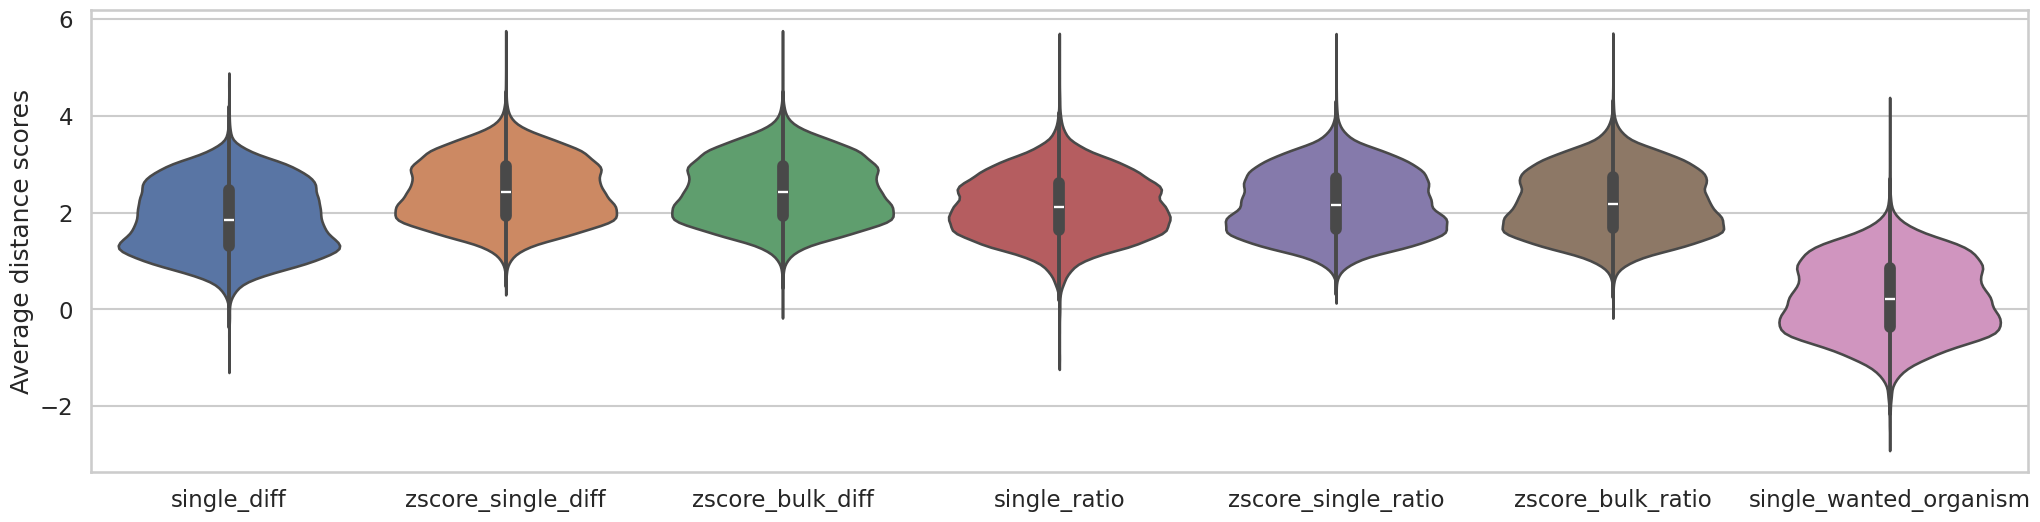

In [19]:
plt.figure(figsize=(25, 6))
ax = sns.violinplot(data=filtered_result[average_distance_score_variant_names])
ax.set_xticklabels([x.removeprefix("average_distance_score_") for x in average_distance_score_variant_names])  # Labels only
plt.ylabel("Average distance scores")
plt.show()

/var/tmp/pbs.4635893.power9.tau.ac.il/ipykernel_533496/2271310345.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.removeprefix("average_distance_non_normalized_score_") for x in average_distance_score_non_normalized_variant_names])  # Labels only


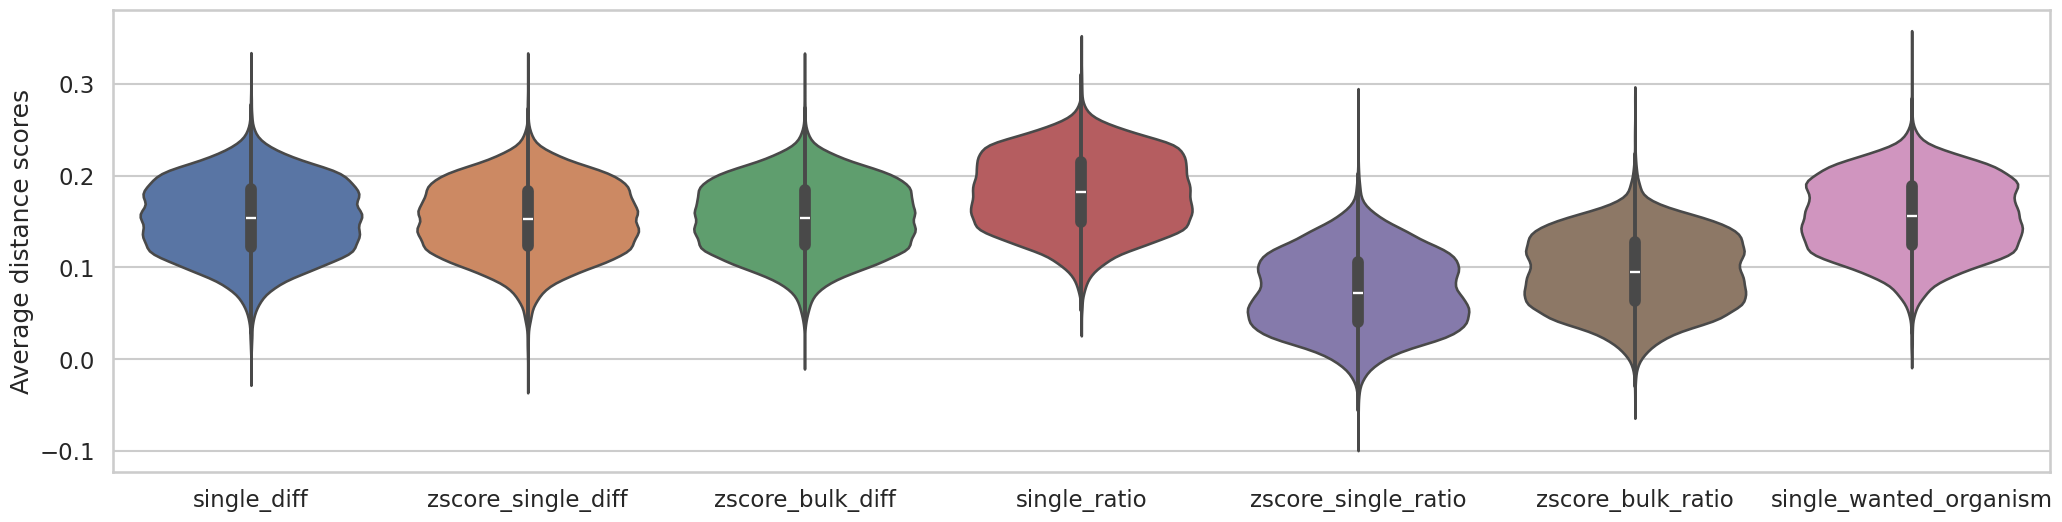

In [24]:
plt.figure(figsize=(25, 6))
ax = sns.violinplot(data=filtered_result[average_distance_score_non_normalized_variant_names])
ax.set_xticklabels([x.removeprefix("average_distance_non_normalized_score_") for x in average_distance_score_non_normalized_variant_names])  # Labels only
plt.ylabel("Average distance scores")
plt.show()

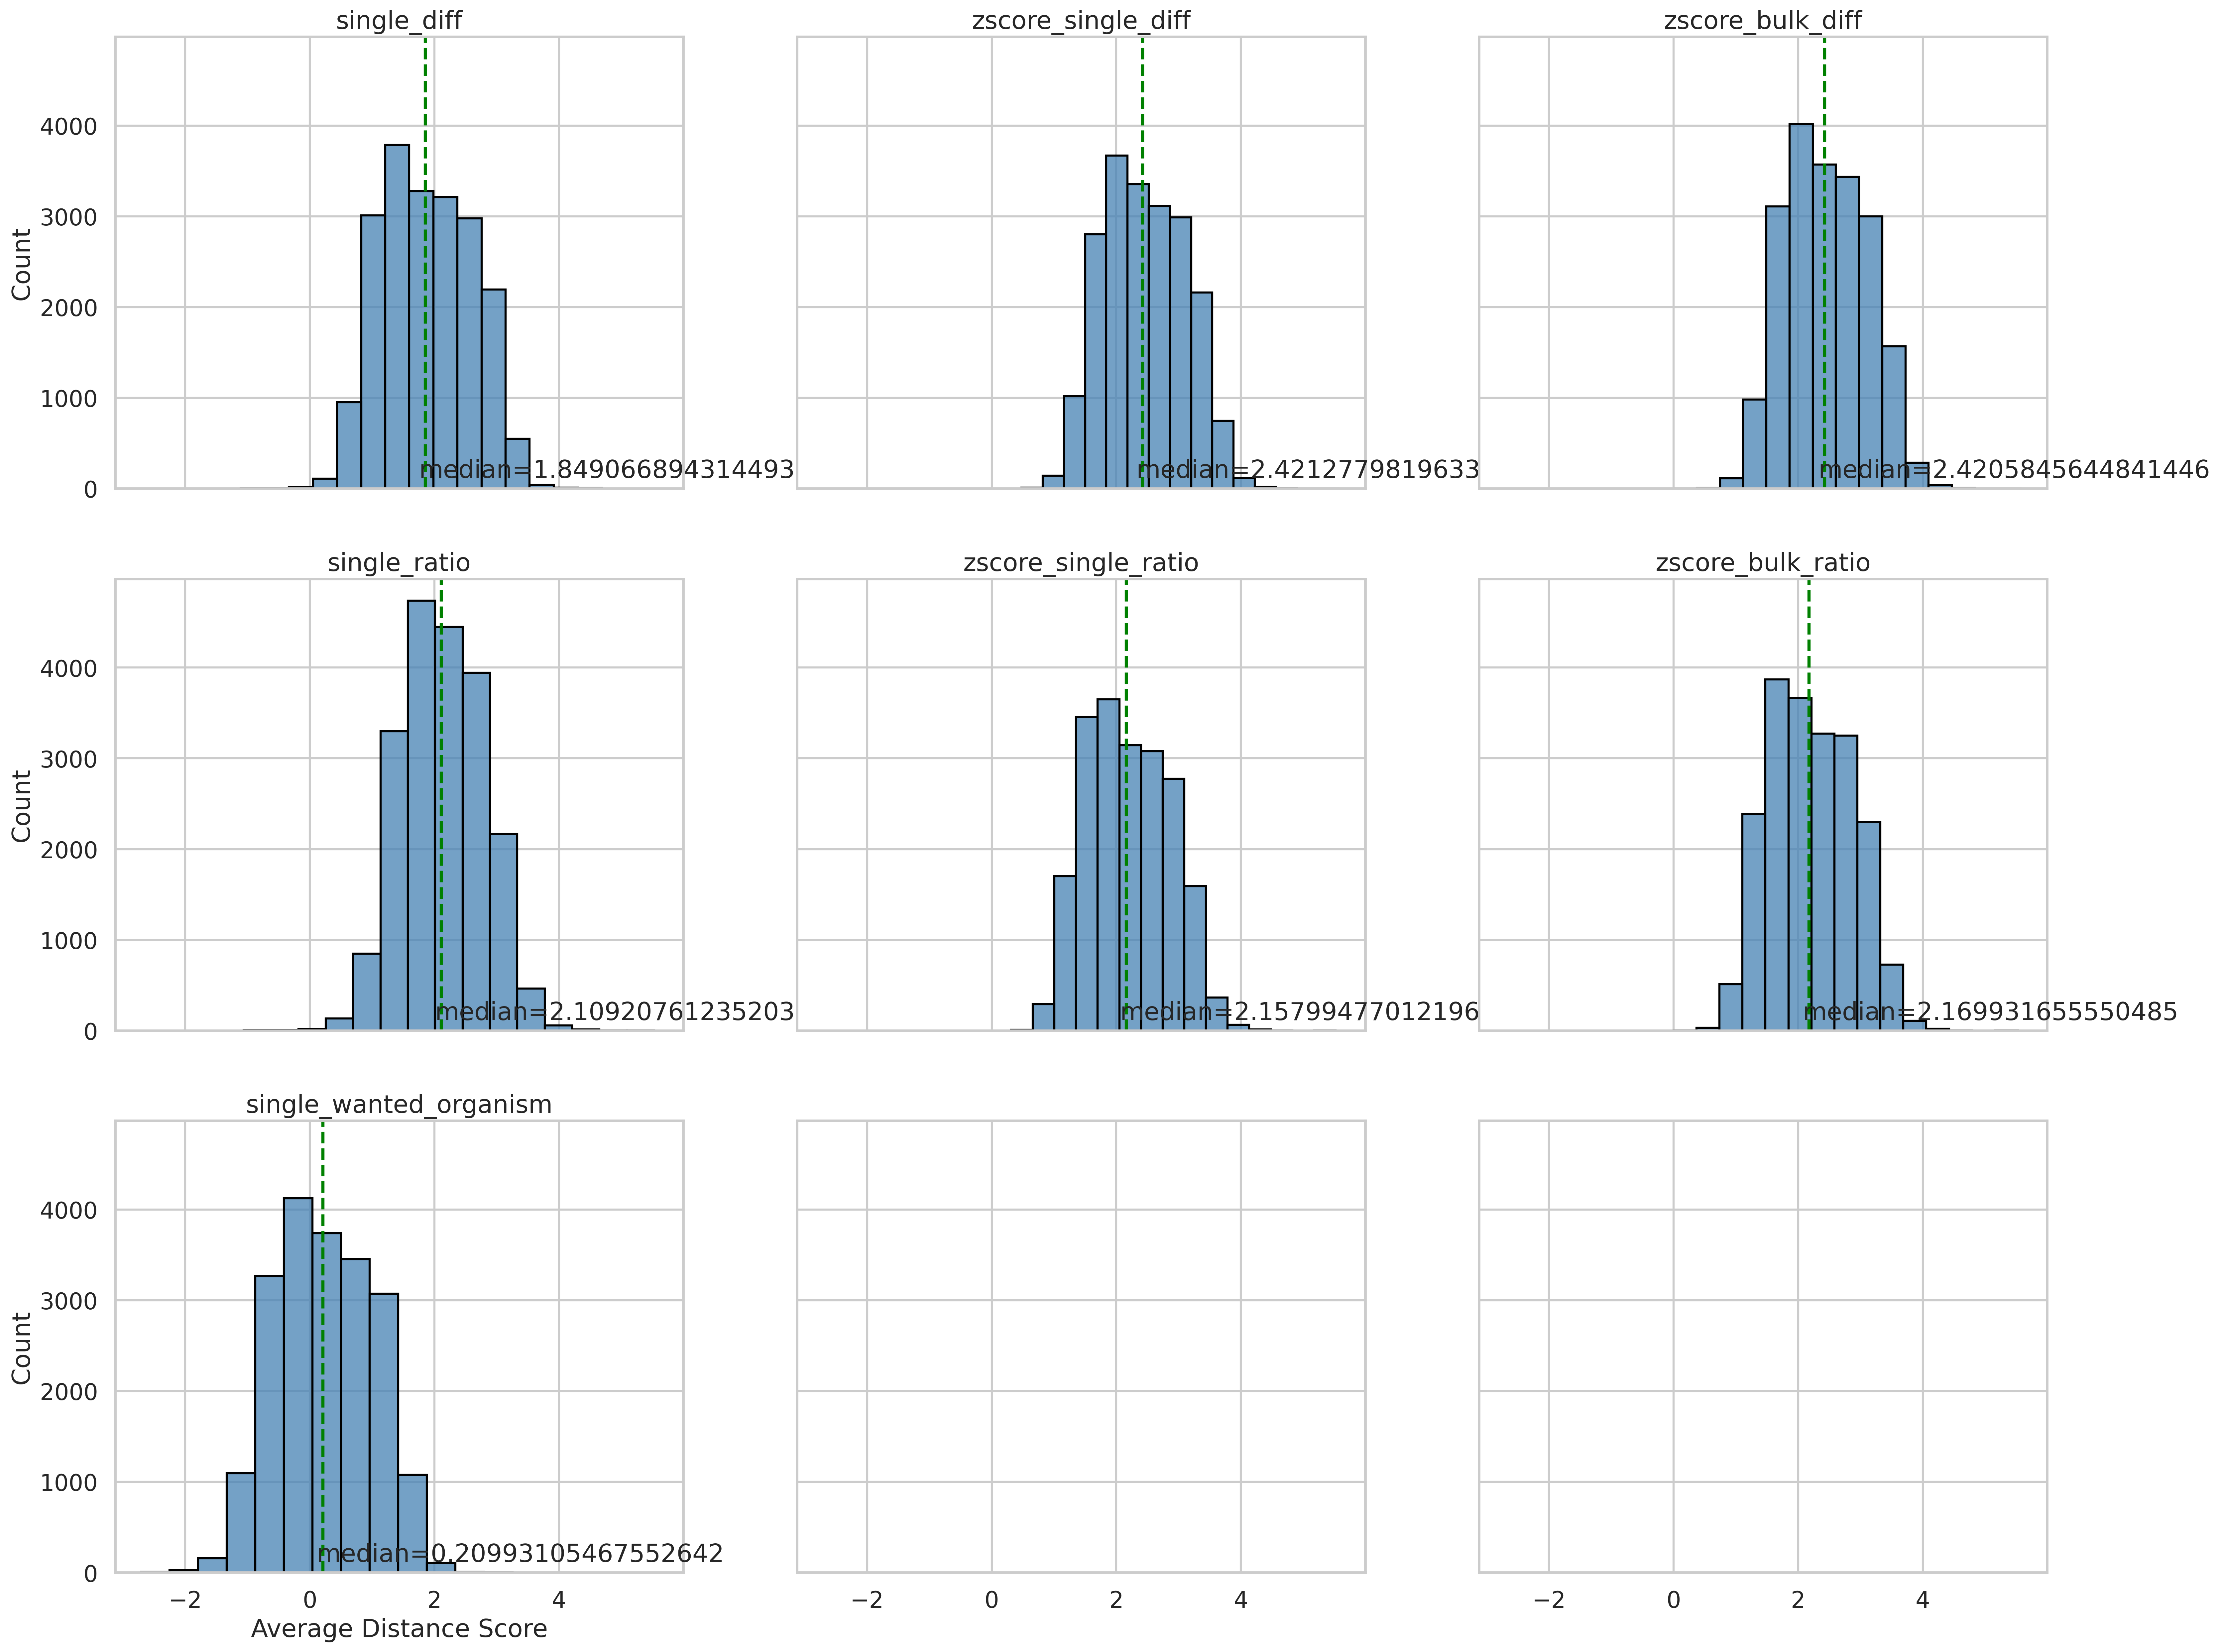

In [14]:
sns.set(style="whitegrid", context="talk")  # 'talk' or 'paper' context

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 20), dpi=300, sharex=True, sharey=True)

axes = axes.flatten()  # Flatten to 1D array for easy indexing

for idx, variant in enumerate(average_distance_score_variant_names):
    sns.histplot(filtered_result[variant], bins=15, kde=False, color='steelblue', edgecolor='black', ax=axes[idx])
    axes[idx].set_title(f"{variant.removeprefix('average_distance_score_')}")
    axes[idx].set_xlabel("Average Distance Score")
    axes[idx].set_ylabel("Count")
    median_value = filtered_result[variant].median()
    axes[idx].axvline(median_value, color="green", linestyle="dashed", label="median")
    axes[idx].text(median_value-0.1, 120, f"median={median_value}")

In [15]:
single_diff_negative = filtered_result[filtered_result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = filtered_result[filtered_result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(filtered_result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(filtered_result) * 100}")

21, percentage:0.10423905489923557
17, percentage:0.08438399682319071
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0


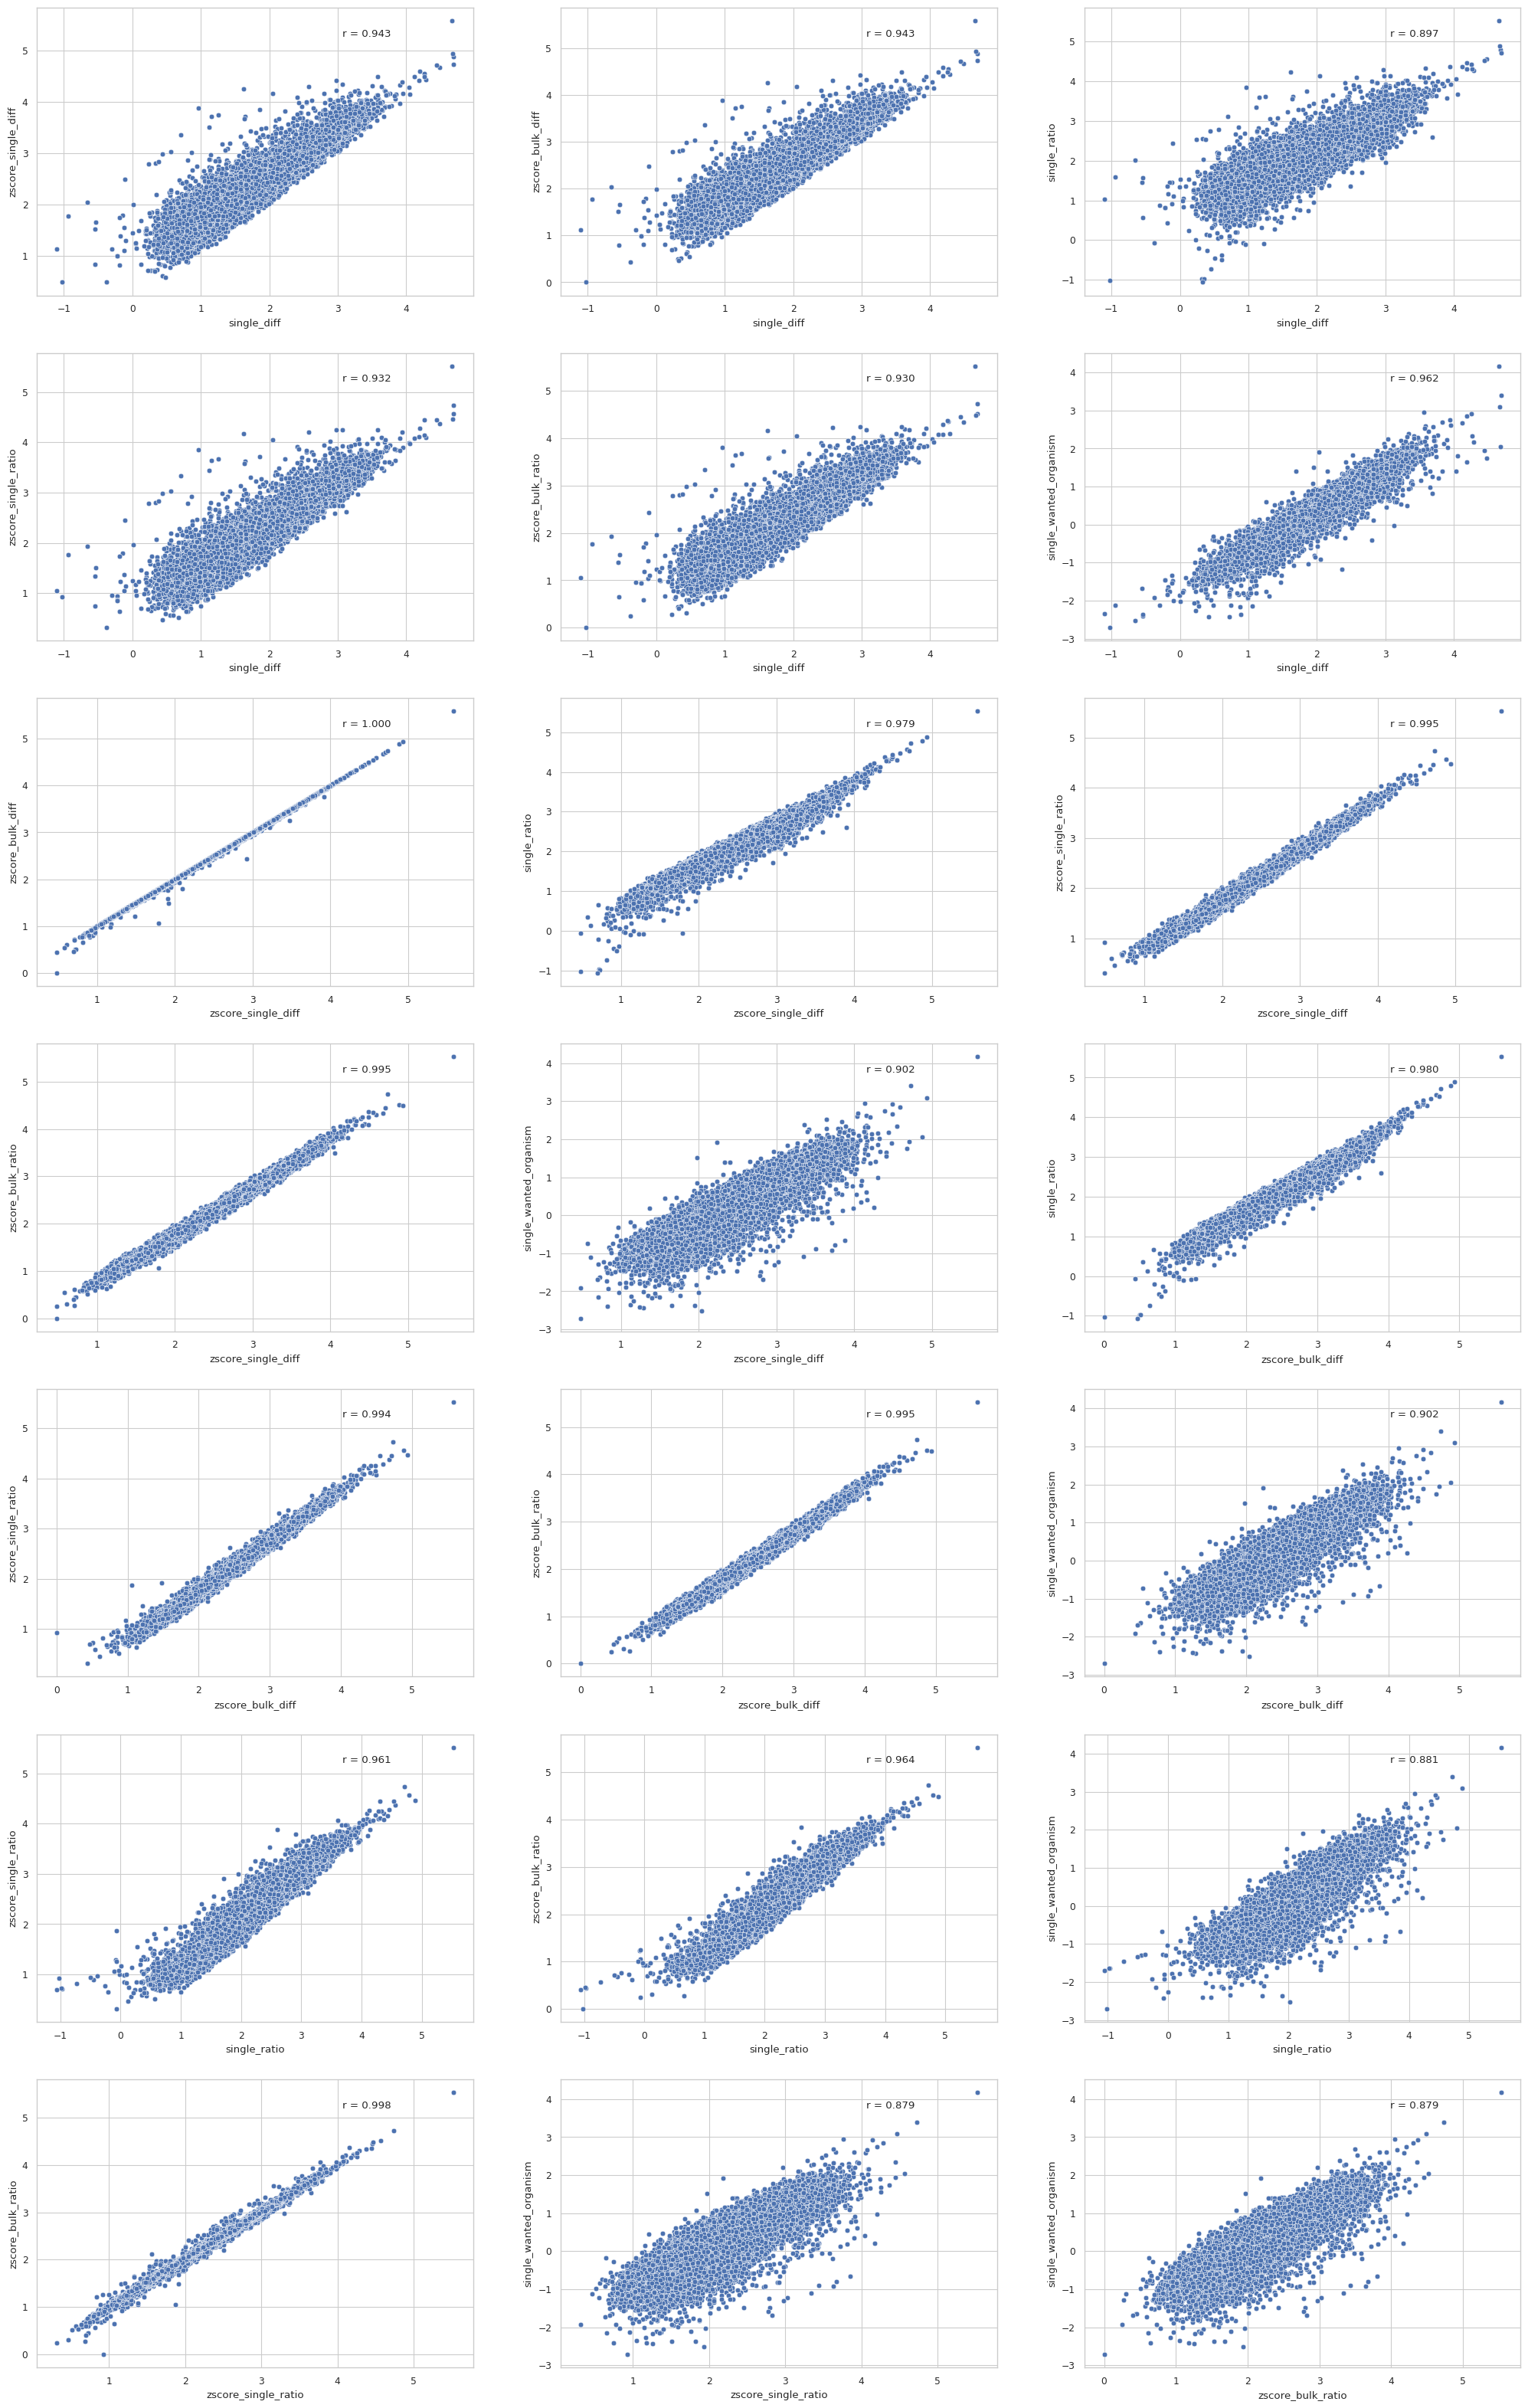

In [16]:
plot_comparative_graphs(filtered_result, "average_distance_score")

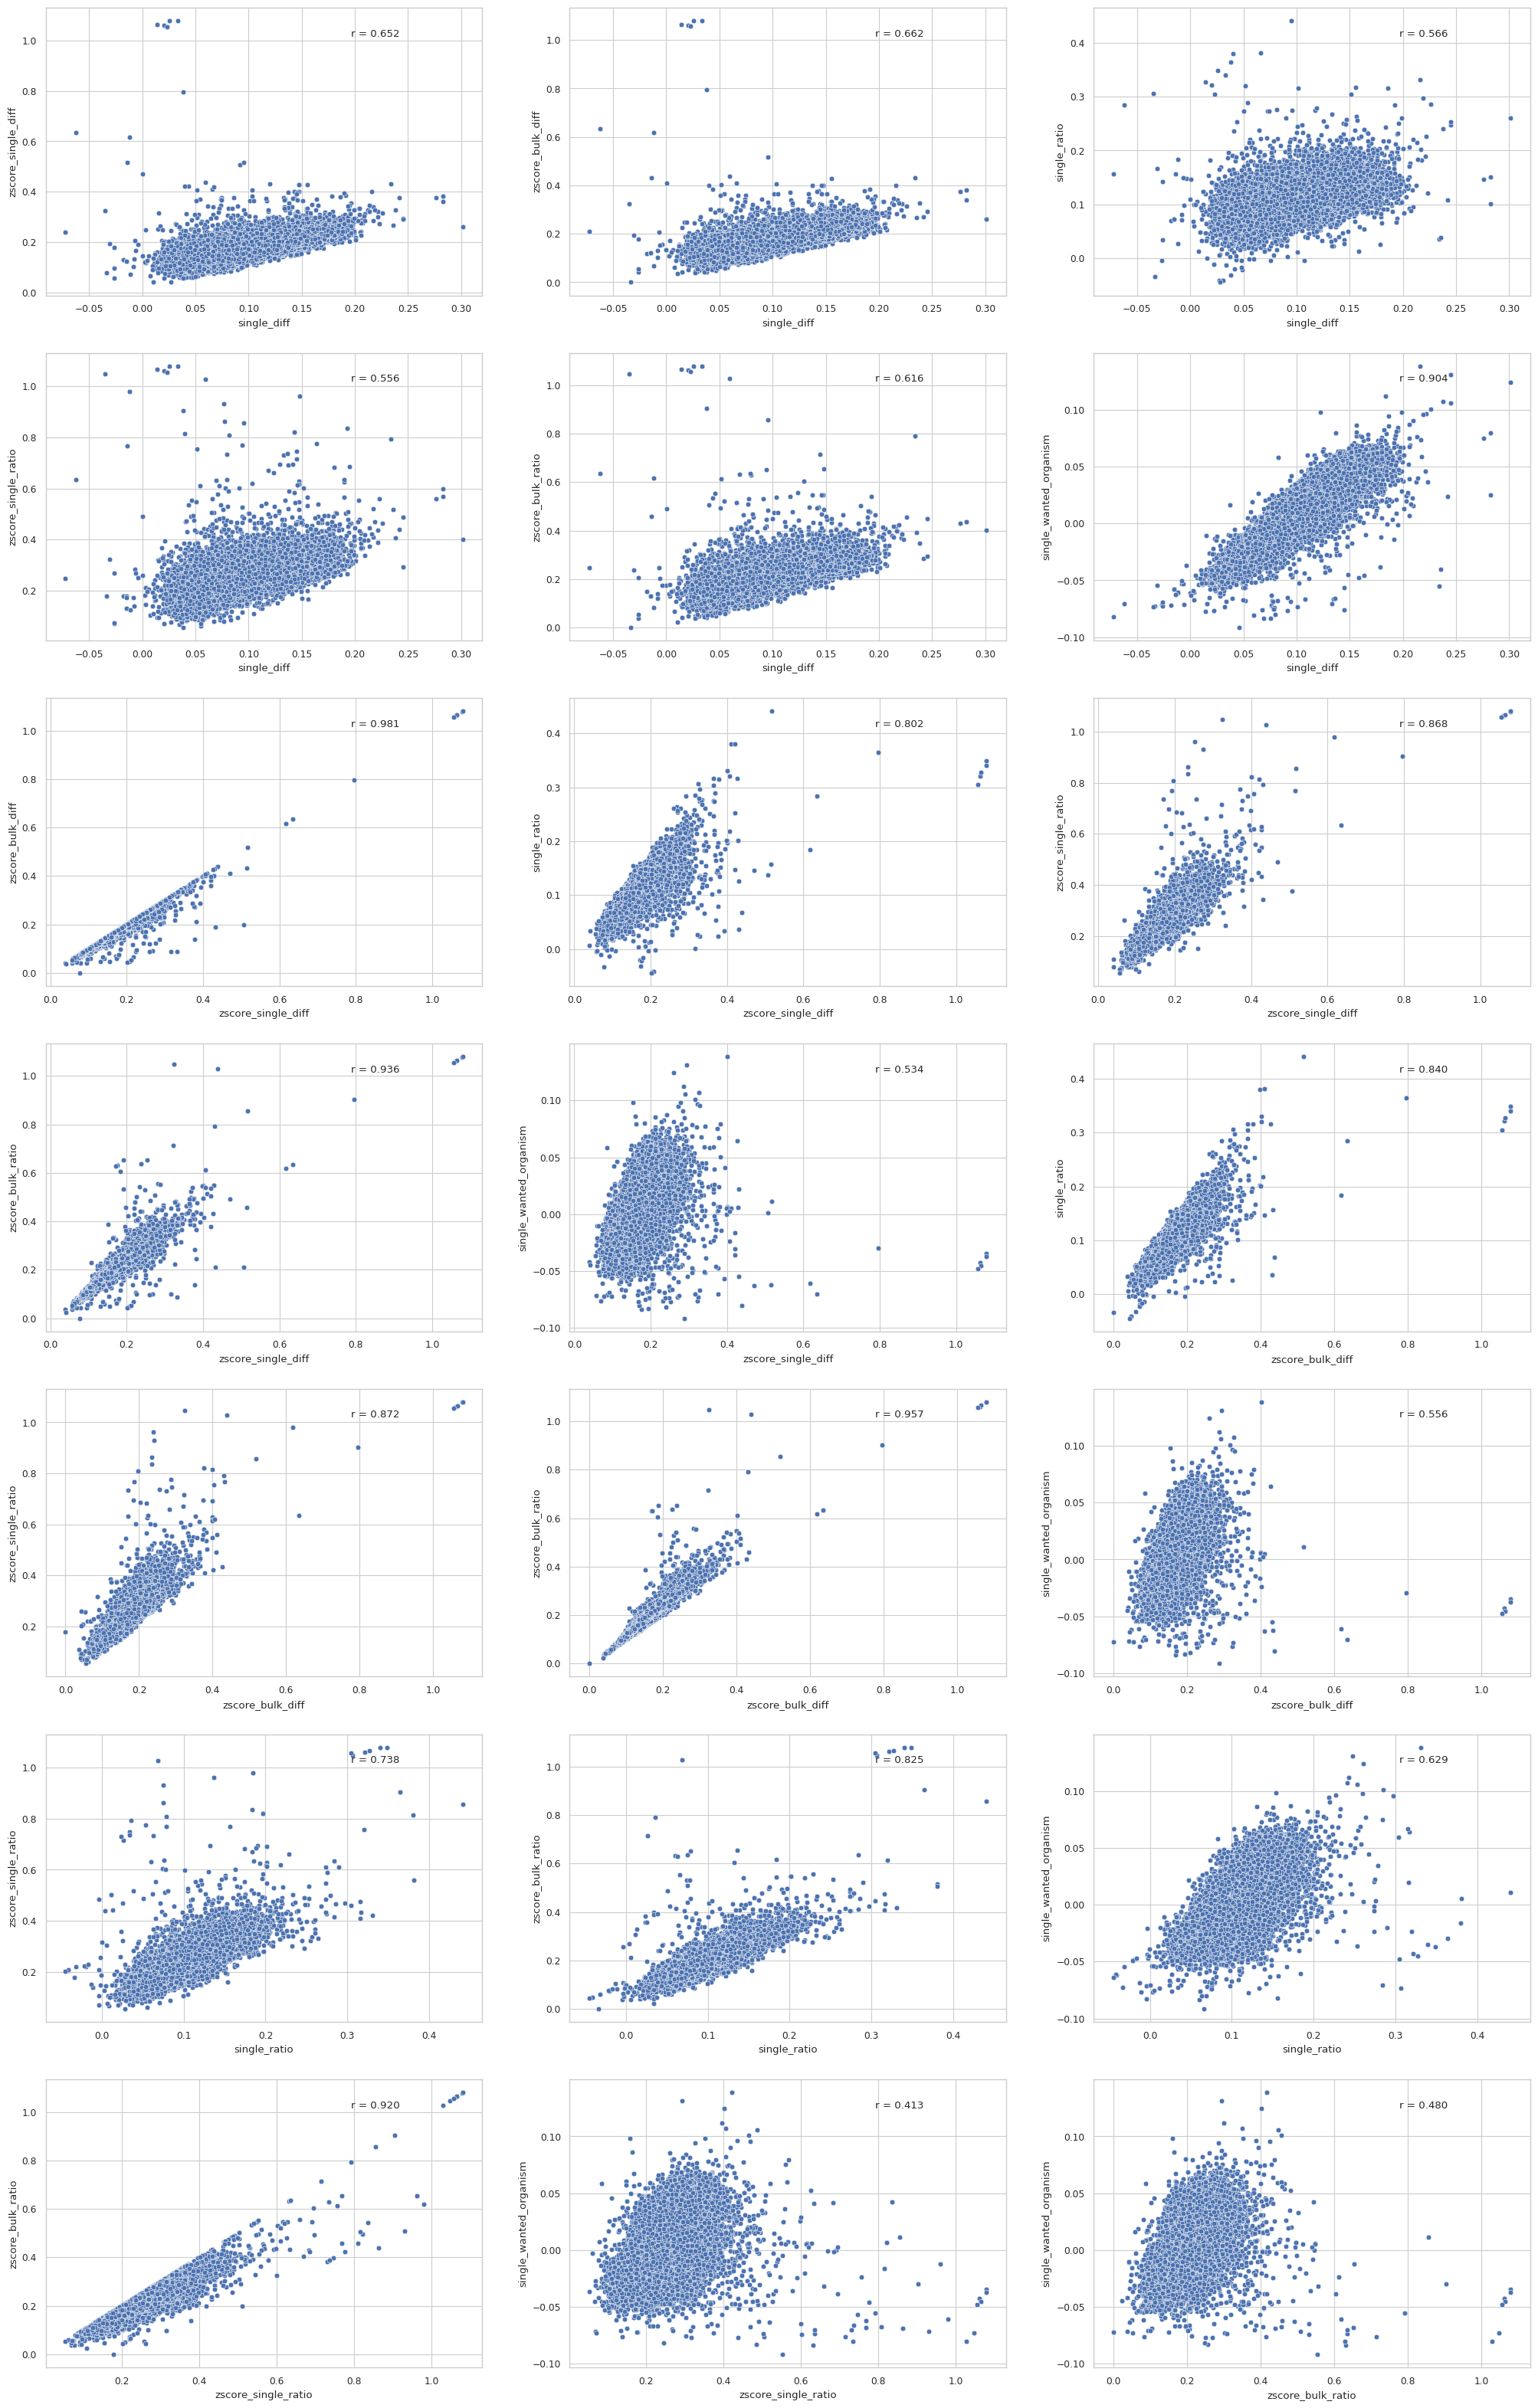

In [17]:
plot_comparative_graphs_log_ratio(filtered_result, "ratio_score")

### Performance evaluation

Text(0.5, 0, 'Run Time (seconds)')

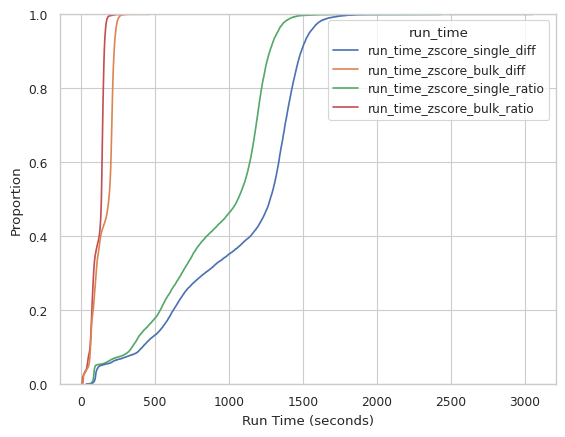

In [18]:
run_time_cols = ["run_time_" +variant_name for variant_name in variant_names if "zscore" in variant_name]

run_times_df = filtered_result[run_time_cols]
run_times_df.index.name = 'run_id'
run_times_df = run_times_df.reset_index()
run_times_df["run_id"] = run_times_df["run_id"] + 1

run_times_long = pd.melt(
    run_times_df, 
    id_vars='run_id', 
    var_name='run_time', 
    value_name='runtime',
)

sns.set(style="whitegrid", context="paper")

# Empirical Cumulative Distribution Function (ECDF)
ecdf = sns.ecdfplot(data=run_times_long, x='runtime', hue='run_time')
ecdf.set_xlabel("Run Time (seconds)")
# handles, labels = ecdf.get_legend_handles_labels()
# new_labels = [x.remvoeprefix("run_time_") for x in labels]
# plt.legend(title="Variant")

## E.coli uwanted, Bacillus wanted

In [19]:
configuration = get_configuration(is_ecoli_optimized=False)
result, errors = get_scores_df_by_configuration_df(configuration)
result

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_bulk_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_bulk_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_single_aa_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/zscore_single_aa_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_codon_ratio


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_codon_diff


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens/e_coli_optimized_False_bacillus_optimized_True/single_wanted_organism


Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, initializing it to select=1:ncpus=4:mem=7630MB
Resource specification for PBS not set, ini

initial_optimization_score_zscore_bulk_ratio  \
0                                          1.119354   
1                                          0.850737   
2                                          0.858439   
3                                          0.872224   
4                                          1.045457   
...                                             ...   
20141                                      1.194980   
20142                                      0.849727   
20143                                      0.968037   
20144                                      1.007210   
20145                                      0.896057   

       final_optimization_score_zscore_bulk_ratio  \
0                                        1.193695   
1                                        1.190792   
2                                        1.195689   
3                                        1.188457   
4                                        1.195452   
...                                           ...   
20141                                    1.191748   
20142                                    1.201011   
20143                                    1.195269   
20144                                    1.195475   
20145                                    1.192155   

       average_distance_score_zscore_bulk_ratio  \
0                                      3.348547   
1                                      5.709975   
2                                      5.017889   
3                                      5.007634   
4                                      3.801746   
...                                         ...   
20141                                  2.900942   
20142                                  5.114962   
20143                                  4.140769   
20144                                  4.028194   
20145                                  4.565667   

       average_distance_non_normalized_score_zscore_bulk_ratio  \
0                                               0.154051         
1                                               0.288766         
2                                               0.242627         
3                                               0.236017         
4                                               0.194177         
...                                                  ...         
20141                                           0.133537         
20142                                           0.247433         
20143                                           0.192770         
20144                                           0.196994         
20145                                           0.219232         

       weakest_link_score_zscore_bulk_ratio  ratio_score_zscore_bulk_ratio  \
0                                  3.348547                       1.339972   
1                                  5.709975                       1.946612   
2                                  5.017889                       1.760749   
3                                  5.007634                       1.721901   
4                                  3.801746                       1.452274   
...                                     ...                            ...   
20141                              2.900942                       1.313310   
20142                              5.114962                       1.804049   
20143                              4.140769                       1.520417   
20144                              4.028194                       1.472370   
20145                              4.565667                       1.601195   

      gene_name orf_optimization_cub_index_zscore_bulk_ratio  \
0         ADAD1                                          CAI   
1         ADAD2                                          CAI   
2           ADA                                          CAI   
3          ADA2                                          CAI   
4         ACYP1                               

In [20]:
homo_sapiens_genes = pd.read_pickle("homo_sapiens_gene_records.pkl")
homo_sapiens_genes_renamed = homo_sapiens_genes.rename(columns={'gene': 'gene_name'})
filtered_result = dd.merge(homo_sapiens_genes_renamed, result, on='gene_name', how='inner')
filtered_result

gene_name                                           sequence  \
0          A1BG  ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...   
1          A1CF  ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...   
2           A2M  ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...   
3         A2ML1  ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...   
4       A3GALT2  ATGGCTCTCAAGGAGGGACTCAGGGCCTGGAAGAGAATCTTCTGGC...   
...         ...                                                ...   
20141    ZYG11A  ATGGTTCATTTCTTGCACCCGGGCCACACGCCCCGGAACATCGTCC...   
20142    ZYG11B  ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...   
20143       ZYX  ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...   
20144     ZZEF1  ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...   
20145      ZZZ3  ATGGCTGCTTCCCGATCTACTCGTGTTACAAGATCAACAGTGGGGT...   

                                                 db_xref  \
0      CCDS:CCDS12976.1,Ensembl:ENSP00000263100.2,Gen...   
1                                           GeneID:29974   
2                                               GeneID:2   
3                                          GeneID:144568   
4      CCDS:CCDS60080.1,Ensembl:ENSP00000475261.1,Gen...   
...                                                  ...   
20141  CCDS:CCDS44148.1,Ensembl:ENSP00000360583.1,Gen...   
20142  CCDS:CCDS30717.1,Ensembl:ENSP00000294353.6,Gen...   
20143  CCDS:CCDS5883.1,Ensembl:ENSP00000324422.5,Gene...   
20144                                       GeneID:23140   
20145                        CCDS:CCDS677.1,GeneID:26009   

                                                 protein      protein_id  \
0                        alpha-1B-glycoprotein precursor     NP_570602.2   
1              APOBEC1 complementation factor isoform X1  XP_047281083.1   
2                       alpha-2-macroglobulin isoform X1  XP_006719119.1   
3        alpha-2-macroglobulin-like protein 1 isoform X1  XP_011518868.1   
4                      alpha-1,3-galactosyltransferase 2  NP_001073907.1   
...                                                  ...             ...   
20141                 protein zyg-11 homolog A isoform 1  NP_001004339.2   
20142                           protein zyg-11 homolog B     NP_078922.1   
20143                                    zyxin isoform 1     NP_003452.1   
20144  zinc finger ZZ-type and EF-hand domain-contain...  XP_016879871.1   
20145  ZZ-type zinc finger-containing protein 3 isofo...  NP_001363075.1   

                                                location gbkey exception  \
0      complement(join(58347022..58347029,58347353..5...   CDS       NaN   
1      complement(join(50806729..50806880,50809894..5...   CDS       NaN   
2      complement(join(9068052..9068224,9068740..9068...   CDS       NaN   
3      join(8822652..8822713,8823182..8823365,8823720...   CDS       NaN   
4      complement(join(33306766..33307453,33312052..3...   CDS       NaN   
...                                                  ...   ...       ...   
20141  join(52842884..52842973,52854465..52854630,528...   CDS       NaN   
20142  join(52726654..52726683,52756458..52756623,527...   CDS       NaN   
20143  join(143381572..143381779,143382248..143382447...   CDS       NaN   
20144  complement(join(4008790..4008954,4009604..4009...   CDS       NaN   
20145  complement(join(77565640..77565784,77566081..7...   CDS       NaN   

      transl_except partial  ...  \
0               NaN     NaN  ...   
1               NaN     NaN  ...   
2               NaN     NaN  ...   
3               NaN     NaN  ...   
4               NaN     NaN  ...   
...             ...     ...  ...   
20141           NaN     NaN  ...   
20142           NaN     NaN  ...   
20143           NaN     NaN  ...   
20144           NaN     NaN  ...   
20145           NaN     NaN  ...   

      final_optimization_score_single_wanted_organism  \
0                                                None   
1                                                None   
2             

In [26]:
# TODO - run this to back up results and save working time
filtered_result_path = "analysis/results/homo_sapiens/processed/ecoli_uwanted_bacillus_wanted.pkl"
# filtered_result.to_pickle(filtered_result_path)
filtered_result = pd.read_pickle(filtered_result_path)

### Scores Evaluation

/var/tmp/pbs.4635893.power9.tau.ac.il/ipykernel_533496/3905703843.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.removeprefix("average_distance_score_") for x in average_distance_score_variant_names])  # Labels only


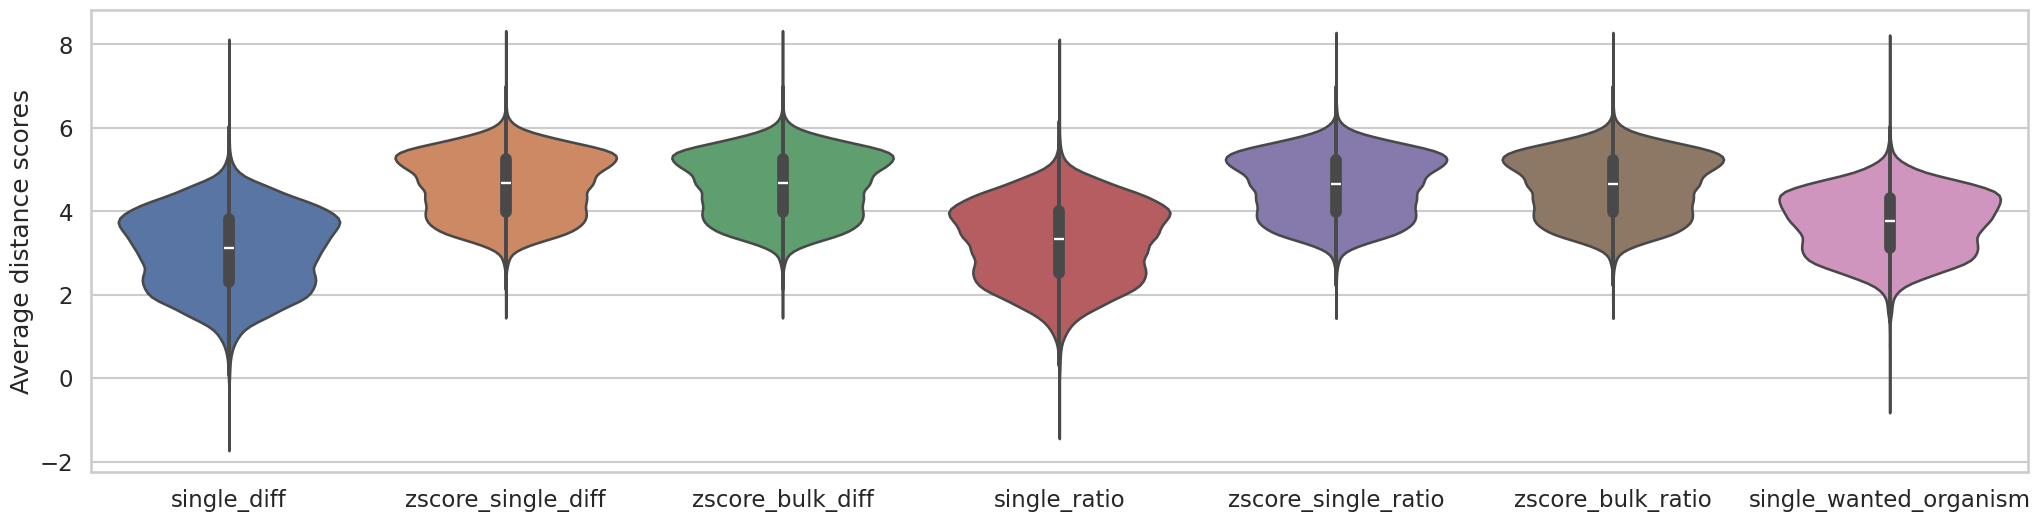

In [27]:
plt.figure(figsize=(25, 6))
ax = sns.violinplot(data=filtered_result[average_distance_score_variant_names])
ax.set_xticklabels([x.removeprefix("average_distance_score_") for x in average_distance_score_variant_names])  # Labels only
plt.ylabel("Average distance scores")
plt.show()

/var/tmp/pbs.4635893.power9.tau.ac.il/ipykernel_533496/2271310345.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.removeprefix("average_distance_non_normalized_score_") for x in average_distance_score_non_normalized_variant_names])  # Labels only


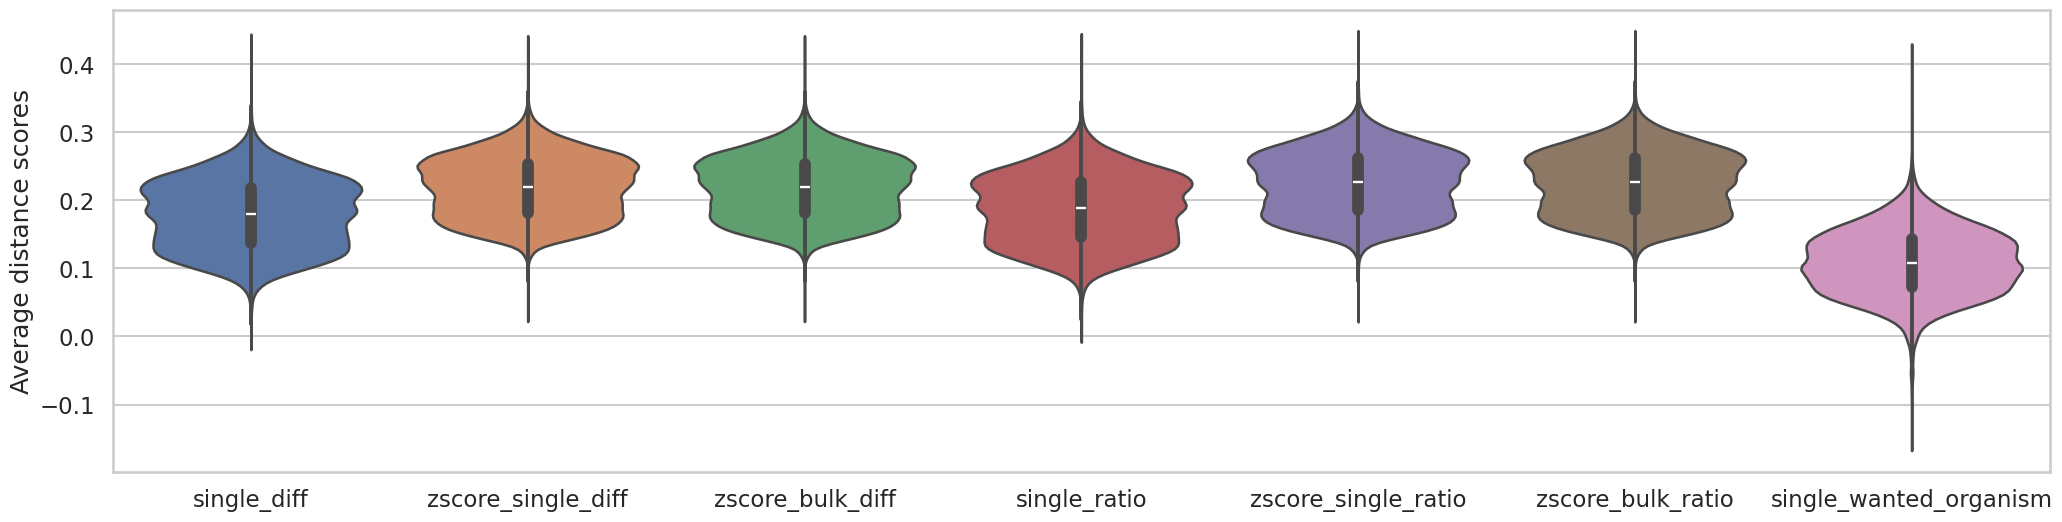

In [29]:
plt.figure(figsize=(25, 6))
ax = sns.violinplot(data=filtered_result[average_distance_score_non_normalized_variant_names])
ax.set_xticklabels([x.removeprefix("average_distance_non_normalized_score_") for x in average_distance_score_non_normalized_variant_names])  # Labels only
plt.ylabel("Average distance scores")
plt.show()

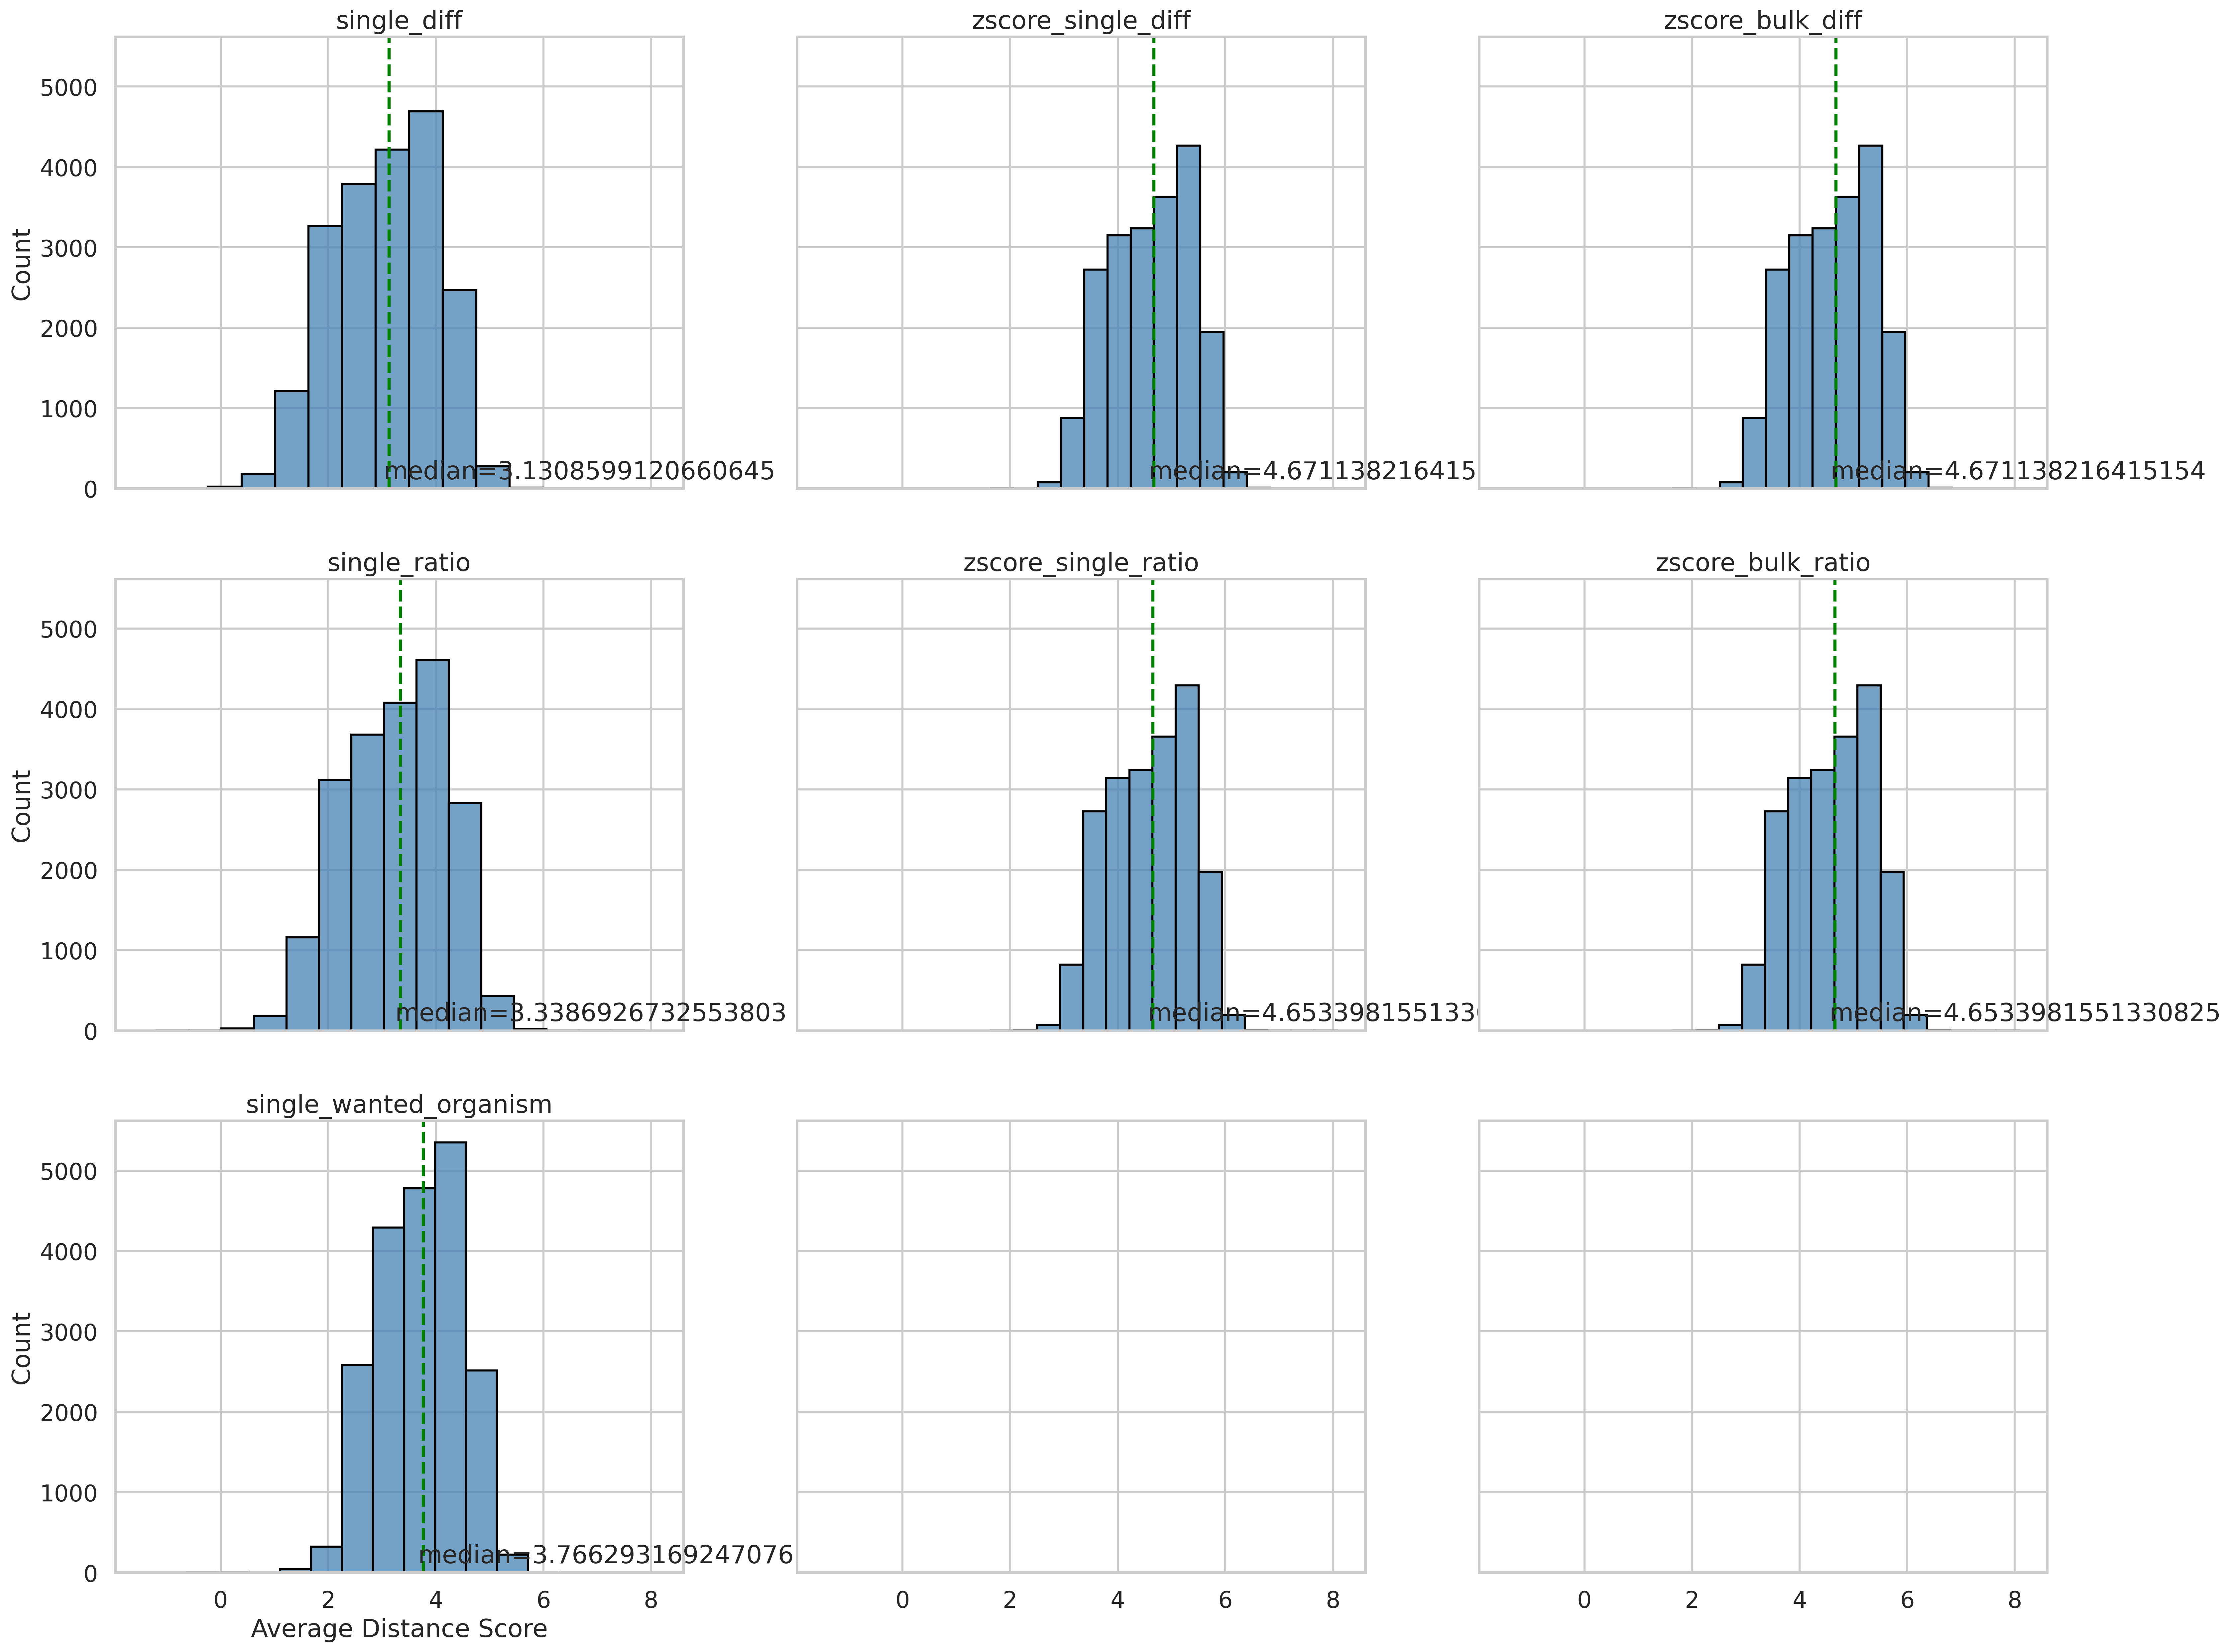

In [11]:
sns.set(style="whitegrid", context="talk")  # 'talk' or 'paper' context

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 20), dpi=300, sharex=True, sharey=True)

axes = axes.flatten()  # Flatten to 1D array for easy indexing

for idx, variant in enumerate(average_distance_score_variant_names):
    sns.histplot(filtered_result[variant], bins=15, kde=False, color='steelblue', edgecolor='black', ax=axes[idx])
    axes[idx].set_title(f"{variant.removeprefix('average_distance_score_')}")
    axes[idx].set_xlabel("Average Distance Score")
    axes[idx].set_ylabel("Count")
    median_value = filtered_result[variant].median()
    axes[idx].axvline(median_value, color="green", linestyle="dashed", label="median")
    axes[idx].text(median_value-0.1, 120, f"median={median_value}")

In [24]:
single_diff_negative = filtered_result[filtered_result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = filtered_result[filtered_result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(filtered_result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(filtered_result) * 100}")

5, percentage:0.024818822595056092
2, percentage:0.009927529038022435
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0


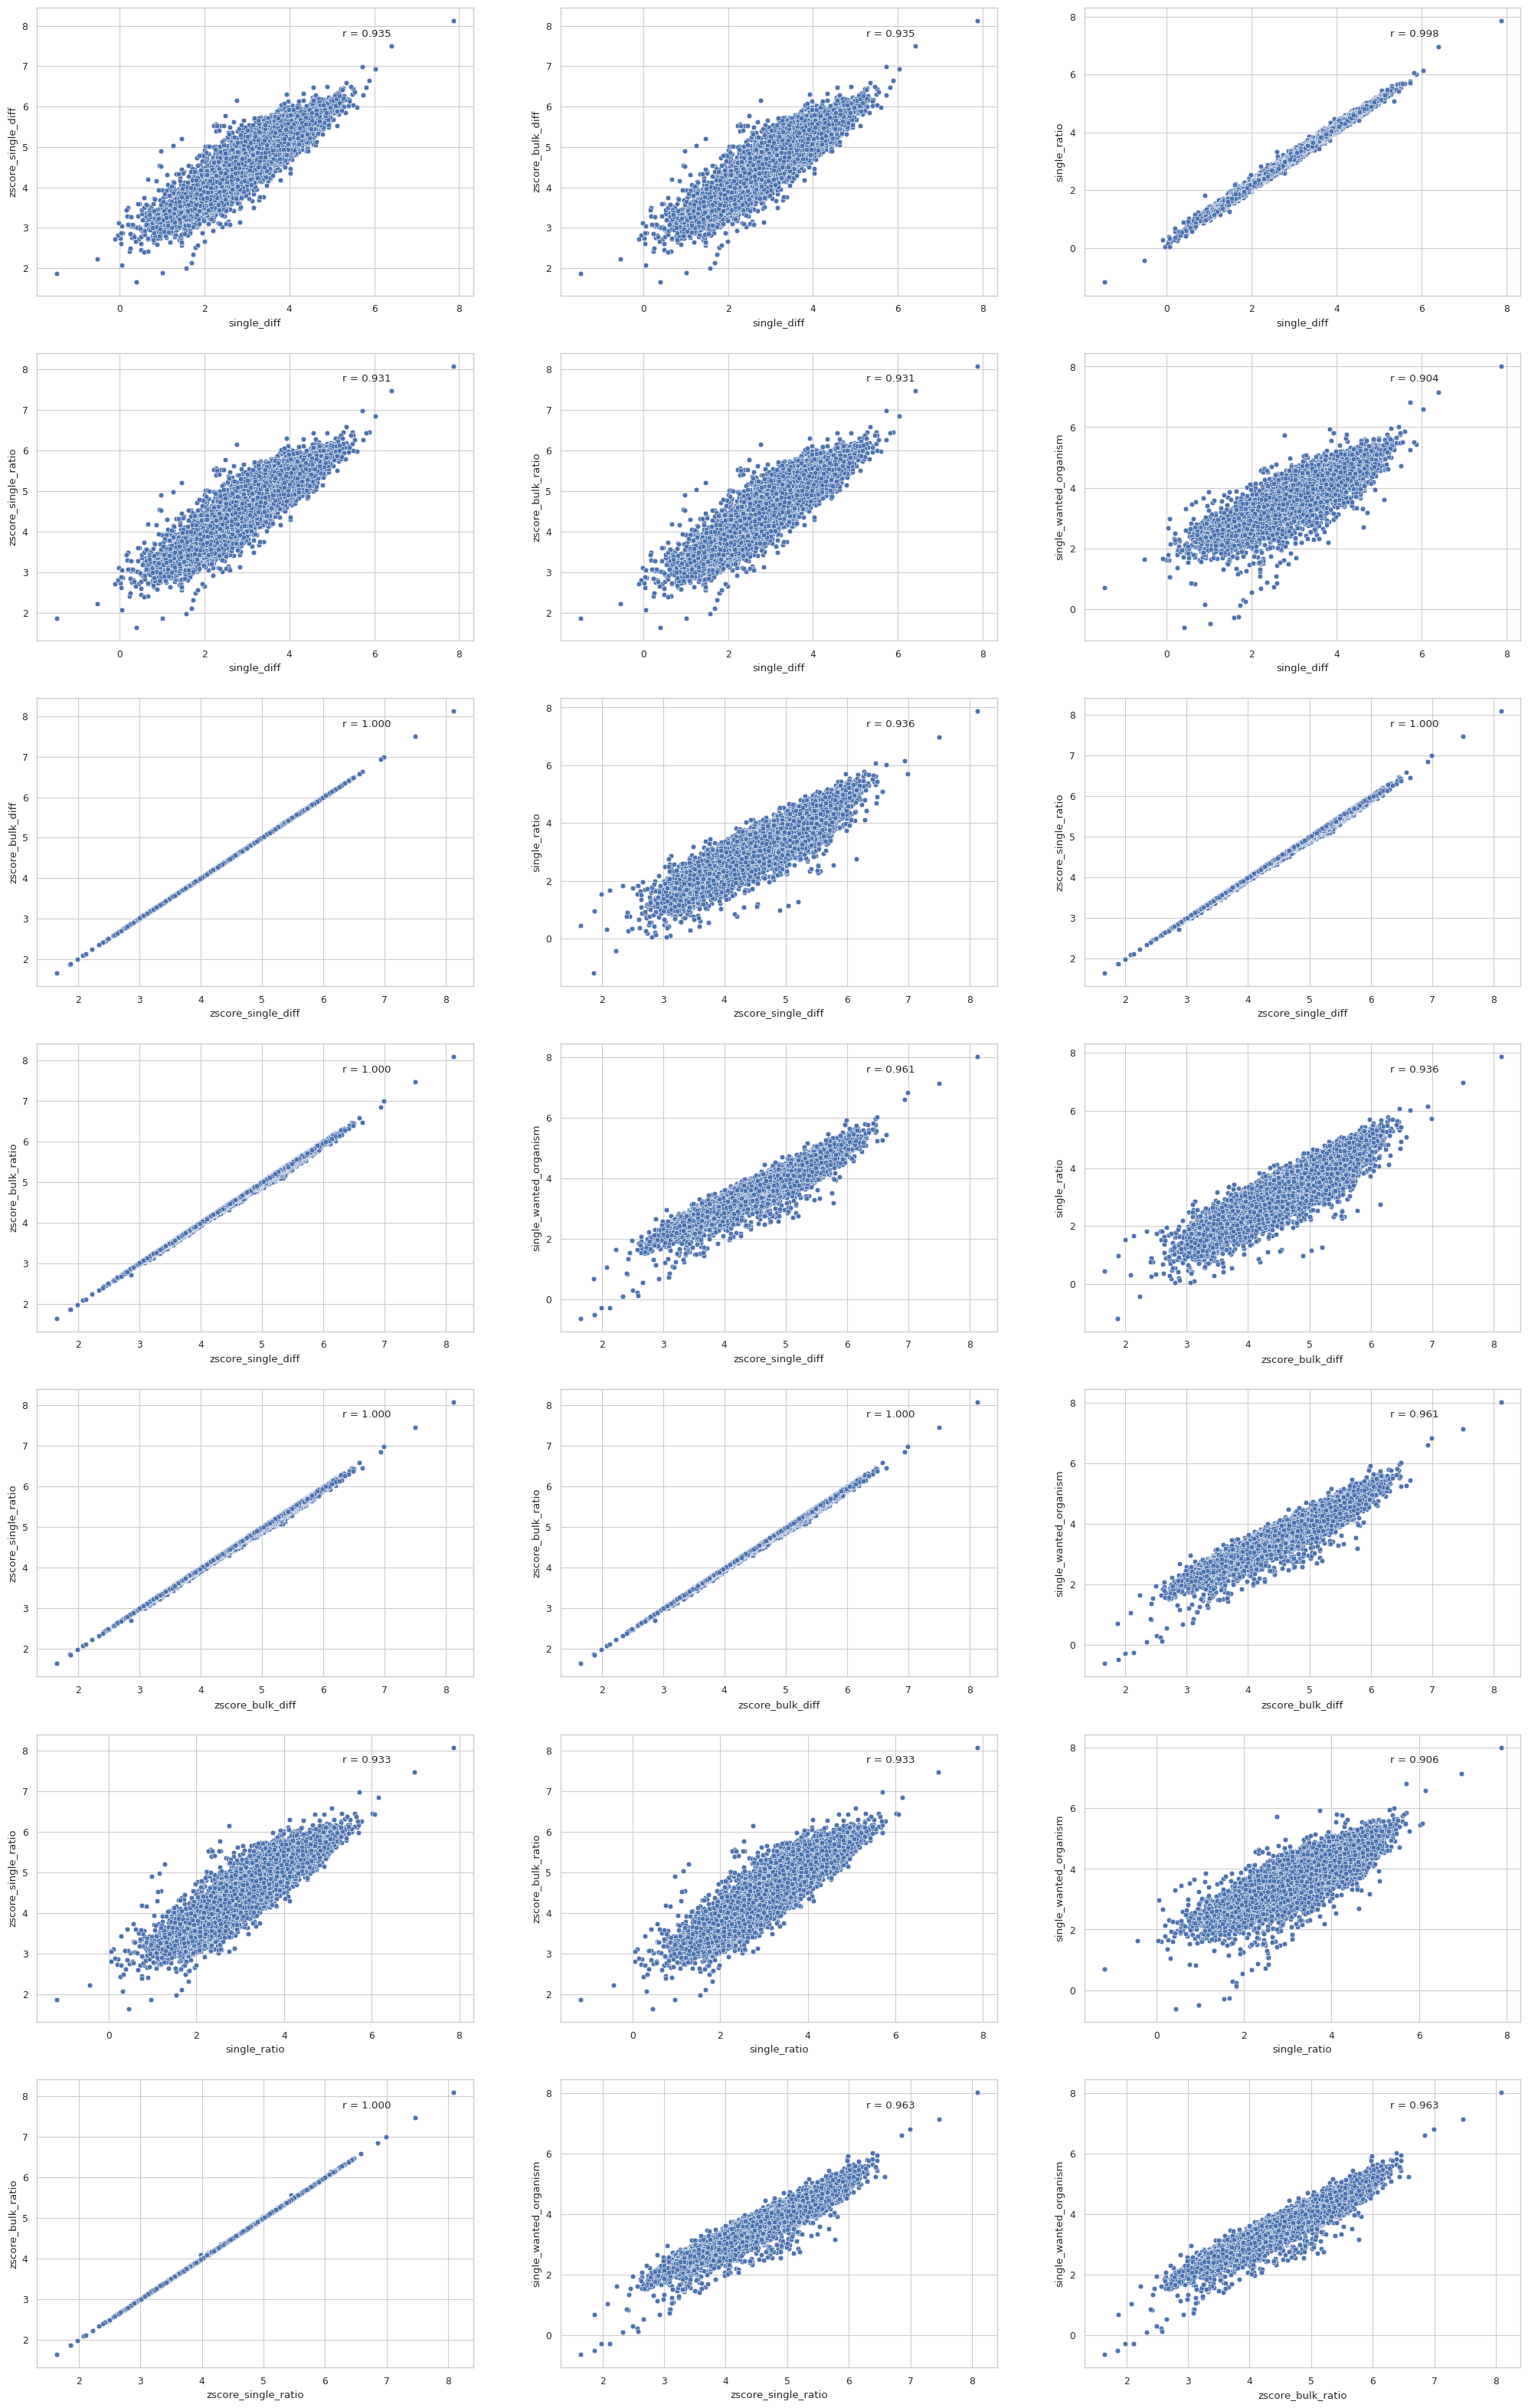

In [27]:
plot_comparative_graphs(filtered_result, "average_distance_score")

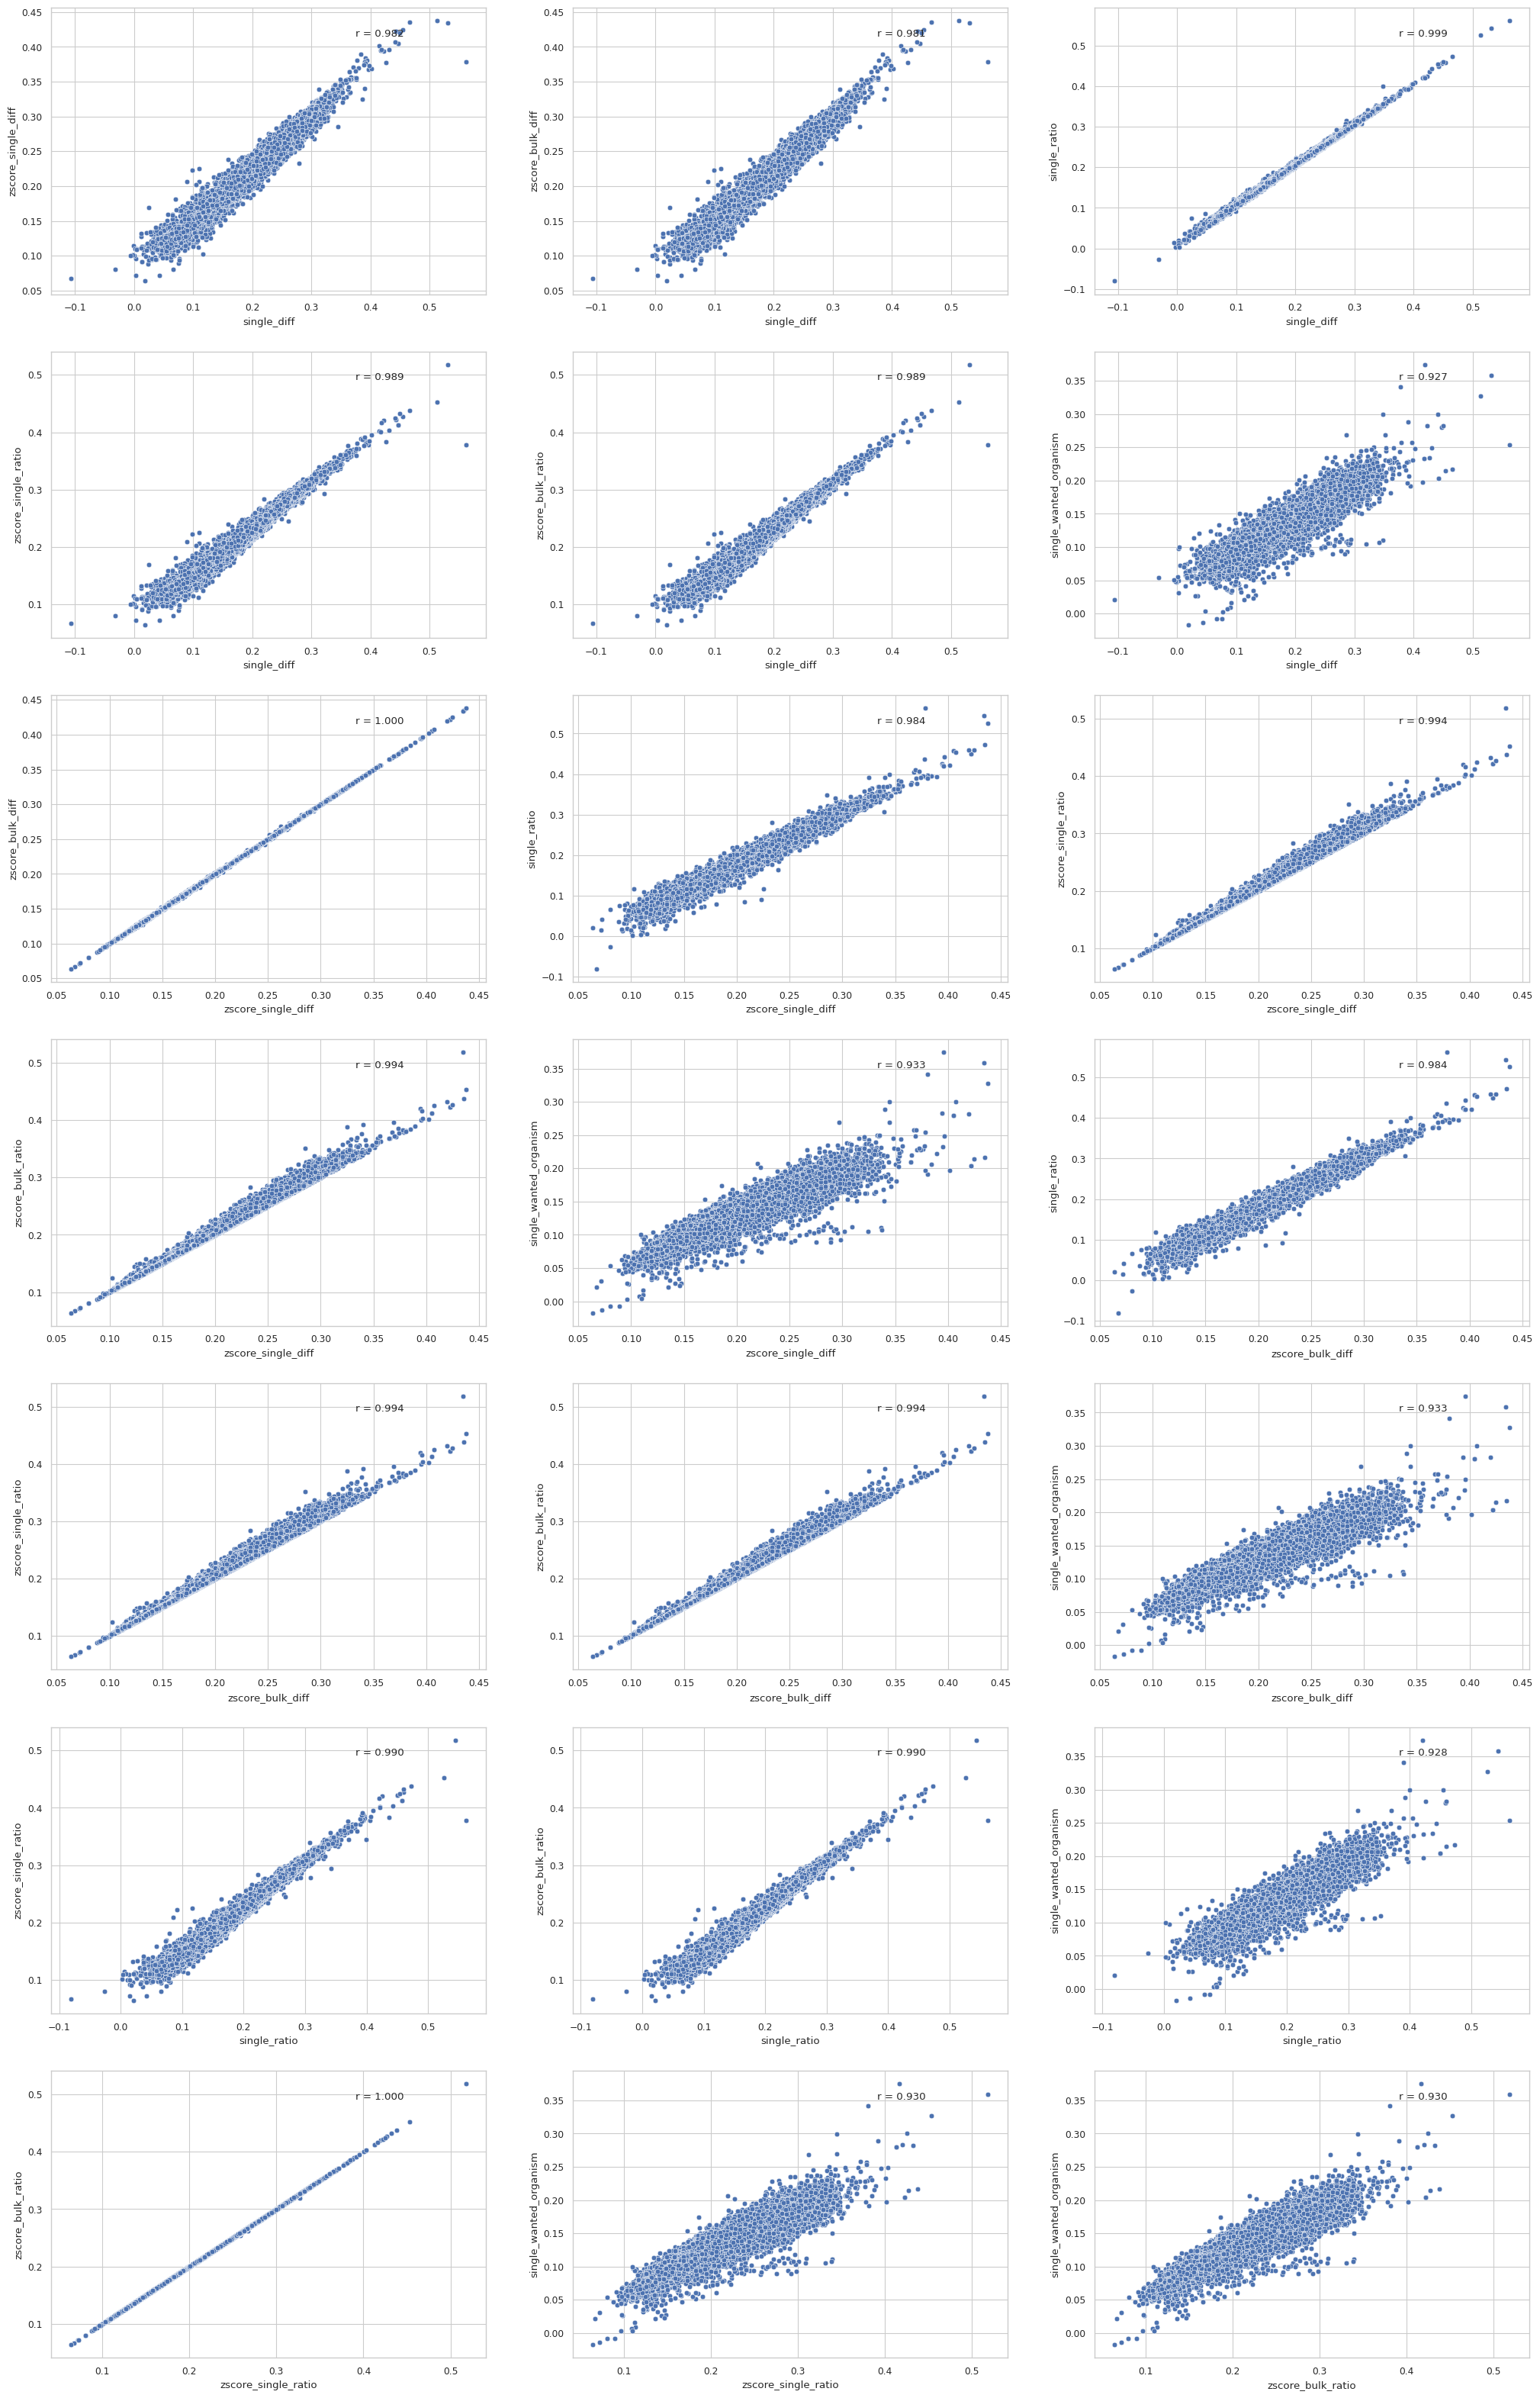

In [28]:
plot_comparative_graphs_log_ratio(filtered_result, "ratio_score")

### Performance Evaluation

Text(0.5, 0, 'Run Time (seconds)')

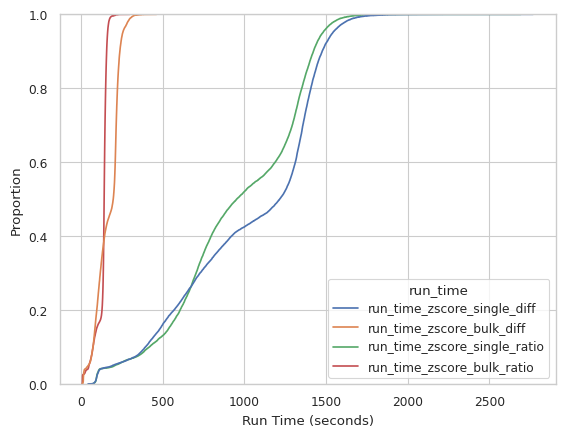

In [29]:
run_time_cols = ["run_time_" +variant_name for variant_name in variant_names if "zscore" in variant_name]

run_times_df = filtered_result[run_time_cols]
run_times_df.index.name = 'run_id'
run_times_df = run_times_df.reset_index()
run_times_df["run_id"] = run_times_df["run_id"] + 1

run_times_long = pd.melt(
    run_times_df, 
    id_vars='run_id', 
    var_name='run_time', 
    value_name='runtime',
)

sns.set(style="whitegrid", context="paper")

# Empirical Cumulative Distribution Function (ECDF)
ecdf = sns.ecdfplot(data=run_times_long, x='runtime', hue='run_time')
ecdf.set_xlabel("Run Time (seconds)")
# handles, labels = ecdf.get_legend_handles_labels()
# new_labels = [x.remvoeprefix("run_time_") for x in labels]
# plt.legend(title="Variant")

## Debug Results 

In [31]:
worse_single_diff = filtered_result[filtered_result["average_distance_score_single_diff"] < filtered_result["average_distance_score_single_wanted_organism"]] 
worse_single_ratio = filtered_result[filtered_result["average_distance_score_single_ratio"] < filtered_result["average_distance_score_single_wanted_organism"]] 

In [35]:
worse_single_diff.iloc[0].sequence

'ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGGGCCCAGTGACAGAAGCAGCCATATTTTATGAGACGCAGCCCAGCCTGTGGGCAGAGTCCGAATCACTGCTGAAACCCTTGGCCAATGTGACGCTGACGTGCCAGGCCCACCTGGAGACTCCAGACTTCCAGCTGTTCAAGAATGGGGTGGCCCAGGAGCCTGTGCACCTTGACTCACCTGCCATCAAGCACCAGTTCCTGCTGACGGGTGACACCCAGGGCCGCTACCGCTGCCGCTCGGGCTTGTCCACAGGATGGACCCAGCTGAGCAAGCTCCTGGAGCTGACAGGGCCAAAGTCCTTGCCTGCTCCCTGGCTCTCGATGGCGCCAGTGTCCTGGATCACCCCCGGCCTGAAAACAACAGCAGTGTGCCGAGGTGTGCTGCGGGGTGTGACTTTTCTGCTGAGGCGGGAGGGCGACCATGAGTTTCTGGAGGTGCCTGAGGCCCAGGAGGATGTGGAGGCCACCTTTCCAGTCCATCAGCCTGGCAACTACAGCTGCAGCTACCGGACCGATGGGGAAGGCGCCCTCTCTGAGCCCAGCGCTACTGTGACCATTGAGGAGCTCGCTGCACCACCACCGCCTGTGCTGATGCACCATGGAGAGTCCTCCCAGGTCCTGCACCCTGGCAACAAGGTGACCCTCACCTGCGTGGCTCCCCTGAGTGGAGTGGACTTCCAGCTACGGCGCGGGGAGAAAGAGCTGCTGGTACCCAGGAGCAGCACCAGCCCAGATCGCATCTTCTTTCACCTGAACGCGGTGGCCCTGGGGGATGGAGGTCACTACACCTGCCGCTACCGGCTGCATGACAACCAAAACGGCTGGTCCGGGGACAGCGCGCCGGTCGAGCTGATTCTGAGCGATGAGACGCTGCCCGCGCCGGAGTTCTCCCCGGAGCCGGAGTCCGGCAGGGCCTTGCGGCTGCGGTGCCTGGCGCCCCTGGAGGGCGCGCGC